## 创建或打开环境

In [2]:
import os
os.environ["HF_HUB_BASE_URL"] = "https://hf-mirror.com"
os.environ["HF_ENDPOINT"] = "https://hf-mirror.com"  # 设置Hugging Face 镜像站 URL
os.environ["HF_HUB_CACHE"] = r"/data/DiYi/MyWorks_Results/DY-LLM_4SPS-PHM_Project/LLM"  # 缓存路径

# # vLLM 可能识别的环境变量，没用。。。
# os.environ["VLLM_USE_V1"] = '0'
# os.environ["VLLM_HF_HUB_BASE_URL"] = "https://hf-mirror.com"
os.environ["VLLM_DISABLE_ONLINE_CHECKS"] = "1"  # 尝试禁用在线检查
os.environ['CURL_CA_BUNDLE'] = ''
# 上面这句是为了告诉底层的 cURL 库不使用任何 CA 证书进行 SSL/TLS 验证，因为如果启用fast_inference = True, vllm仍然会尝试连接hugging face的官网而并非镜像站，会报错MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443)。因此加这一句使其不验证SSL证书，避免了这个问题。https://github.com/huggingface/transformers/issues/17611

os.environ['CUDA_VISIBLE_DEVICES'] = "7"
# os.environ['CUDA_VISIBLE_DEVICES'] = "2,3"

"""确保 os.environ['CUDA_VISIBLE_DEVICES'] = "2" 在任何 CUDA 初始化代码（如 import torch 或 from transformers import ...）之前设置，
否则没用，某些库（如 torch 或 transformers）可能已经先初始化了 CUDA 环境，导致 CUDA_VISIBLE_DEVICES 设置无效"""

'确保 os.environ[\'CUDA_VISIBLE_DEVICES\'] = "2" 在任何 CUDA 初始化代码（如 import torch 或 from transformers import ...）之前设置，\n否则没用，某些库（如 torch 或 transformers）可能已经先初始化了 CUDA 环境，导致 CUDA_VISIBLE_DEVICES 设置无效'

In [3]:
import torch
print("CUDA Available:", torch.cuda.is_available())
print(torch.cuda.device_count())
import torch
print(torch.version.cuda)  # 检查 PyTorch 编译时的 CUDA 版本
print(torch.backends.cudnn.version())  # 检查 cuDNN 版本

CUDA Available: True
1
12.4
90100


In [4]:
import unsloth  # 导入unsloth库，用于处理大型语言模型
print(unsloth.__version__)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
INFO 05-31 13:19:58 [__init__.py:239] Automatically detected platform cuda.
2025.5.6


In [5]:
"""numpy的版本特别要注意大于2.0.0版本，不然报错：# AttributeError: module 'numpy._core' has no attribute 'multiarray'"""
# https://github.com/huggingface/accelerate/pull/3247

import numpy as np
print(np.__version__)

2.2.5


In [6]:
# 检查其他库
import accelerate
print(accelerate.__version__)
import torch
print(torch.__version__)
import transformers
print(transformers.__version__)
import datasets
print(datasets.__version__)
import requests
print(requests.__version__)
import trl
print(trl.__version__)
import matplotlib
print(matplotlib.__version__)

1.6.0
2.6.0+cu124
4.51.3
3.5.0
2.32.3
0.15.2
3.10.1


## 加载预训练模型

In [ ]:
"""从huggingface加载模型需要走代理，不然中国无法访问huggingface的模型库"""
##### 第一步：从clash获得ip和端口：
###### 打开 Clash 设置 → 确保勾选 "Allow LAN"或者 "局域网连接" 选项
###### 点击 "局域网连接" 选项旁边的小图标 记下IP地址
###### 端口号 也在同页面下方
###### 重启 Clash 客户端使配置生效
# ![clash的IP和端口获取](clash的IP和端口获取.png)

##### 第二步：在本地运行的python中设置代理
###### 就如上个代码单元格

##### 第三步：在windows防火墙里允许clash的端口通过
###### 打开 控制面板——系统和安全——Windows Defender 防火墙——高级设置——入站规则。
###### 在左侧选择 新建规则。创建一条新的规则：
###### 规则类型：端口。
###### 协议和端口：选择 TCP，输入 Clash 的代理端口（如 7890）。
###### 操作：允许连接。
###### 配置文件：选择所有配置文件（域、专用、公用）。
###### 名称：为规则命名（如 "clash for liunx for huggingface20250421"）。

##### 第四步：先关掉local_files_only = True，下载完再打开
###### 运行model, tokenizer = FastLanguageModel.from_pretrained的时候先把local_files_only = True注释掉
###### 下载完才能打开local_files_only = True，不然报错OSError: We couldn't connect to 'https://huggingface.co' to load the files, and couldn't find them in the cached files

##### 第五步：删除一切LLM缓存 rm -rf LLM
###### 初次下载时，模型保存文件夹内缓存一定要全部删除，尤其是之前下载失败留下的缓存文件，不删除的话会不停报错
###### 就是model, tokenizer = FastLanguageModel.from_pretrained里面的cache_dir那个文件夹，一定要清空再下载

##### 第六步：确认huggingface里面unsloth库里你想下载的模型是 pytorch_model.bin 还是 model.safetensors
###### 如果是pytorch_model.bin，直接下载就行
###### 如果是model.safetensors，下载时要加上use_safetensors=True,参数

##### 第七步：若还是下载出错：
###### 更新transformers库：conda install conda-forge::transformers
###### 若是报错OSError: unsloth/deepseek-r1-distill-llama-8b-unsloth-bnb-4bit does not appear to have a file named model.safetensors or model.safetensors.index.json，那这个真没办法，这个issue是他们正在解决的一个问题：https://github.com/unslothai/unsloth/issues/1521
###### 我是把62224的模型搬过来到62229，才终于终于成功载入。至于62224当初咋下载下来的，已经忘了，可能是直接从huggingface上手动下载的吧。
###### 我是先照常下载，报错也不删掉，然后从运行download_model.py从modelscope直接下载到本地，然后把缺失的safetensors和generation_config等 所有文件文件放入之前虽然报错但是创建的snapshots文件夹下面那个下载码文件夹中，全放进去，放不进去的删掉里面的再放进去，再次运行下载，进一步下载其他缺失的文件，这样才终于下载全部文件。
###### 但是可能的解决方法有：删除放LLM的那个cache_dir缓存文件夹、去掉use_safetensors=True先不管什么pytorch还是tensorflow加上它建议的from_tf=True先下载下来再说、也可能是根据https://github.com/unslothai/unsloth/issues/1492#issuecomment-2580117795

##### 第八步：如果设置fast_inference = True,使用 vllm 加速推理服务的话：
###### 1.记得设置 os.environ['CURL_CA_BUNDLE'] = ''  因为vllm脑残，就算设置了镜像站，他还是会尝试连接hugging face的官网而并非镜像站，会报错MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443)。因此通过设置环境变量CURL_CA_BUNDLE = ''来要求vllm不要验证证书，绕过这个问题。如果还是不行，那就不得不连接自己电脑的代理了，如上所述，可参考：https://github.com/huggingface/transformers/issues/17611 
###### 同时，还要设置os.environ["VLLM_DISABLE_ONLINE_CHECKS"] = "1"  # 禁用 vLLM 在线检查
###### 2.使用vllm的0.8.2版本，如果报错RuntimeError: Can't pickle local object 'patch_vllm_compute_dtype.<locals>.BitsAndBytesConfig'  原因不明，参考https://github.com/unslothai/unsloth/issues/2298 和 设置os.environ["VLLM_USE_V1"] = '0'，https://github.com/unslothai/unsloth/issues/2299#issuecomment-2782067709
###### 3.设置默认huggingface缓存路径 os.environ["HF_HUB_CACHE"] = "/data/DiYi/MyWorks_Results/DY-LLM_4SPS-PHM_Project/LLM"  因为一旦设置fast_inference = True开启了vllm，vllm像个智障一样不能识别你设置的cache_dir参数，直接把模型下载到home盘的.cache/huggingface/下面了，占用C盘就算了，他还识别不到自己下载的文件，会报各种错 RuntimeError: An error happened while trying to locate the file on the Hub and we cannot find the requested files in the local cache.
###### 4. 若报错 not a string 。先尝试最前面定义os.environ["HF_HUB_CACHE"]或者后面函数填路径时，前面加个r，声明一下字符串。若是这样还不行，那就是导入时判定少了某些文件，解决方法是从ModelScope直接全部在下载下来，然后FastLanguageModel.from_pretrained的时候model_name参数直接填上ModelScope的下载下来模型路径，比如model_name = r'/data/DiYi/MyWorks_Results/DY-LLM_4SPS-PHM_Project/LLM/ModelScope_unsloth_DeepSeek-R1-Distill-Qwen-14B-bnb-4bit'，直接从本地加载模型。



"""解决方案一：下面是通过liunx连接我的clash代理来下载huggingface的模型"""
# import os
# os.environ["HTTP_PROXY" ] = "http://your-ip-here:your-port-here"
# os.environ["HTTPS_PROXY"] = "http://your-ip-here:your-port-here"
# proxies = {
#     "http": "http://your-ip-here:your-port-here",
#     "https": "http://your-ip-here:your-port-here"
# }
# import requests
# response = requests.get("https://huggingface.co")   # 测试访问 Hugging Face
# print(response.status_code)  # 如果返回 200，说明代理生效



"""解决方案二：当然也可以 连接国内的huggingface的镜像站，选一个、注释另一个运行即可"""
# from huggingface_hub import configure_hf
# configure_hf(mirror="https://hf-mirror.com")  # 设置Hugging Face的镜像源为
'以下三句放在代码最前面，才生效！！！！！！！！！！！'
import os
os.environ["HF_HUB_BASE_URL"] = "https://hf-mirror.com"
os.environ["HF_ENDPOINT"] = "https://hf-mirror.com"  # 设置Hugging Face 镜像站 URL
# os.environ['CURL_CA_BUNDLE'] = '' # 设置证书路径，空字符串即不验证证书，用于解决vllm连接hugging face报错

import requests
response = requests.get("https://hf-mirror.com")   # 测试访问 Hugging Face
print(response.status_code)  # 如果返回 200，说明代理生效


200


In [8]:
from unsloth import FastLanguageModel  # 导入FastLanguageModel类，用来加载和使用模型
import torch  # 导入torch工具，用于处理模型的数学运算

"""以下两个变量说的是经过分词器处理的最大 token 数量，与字符串字符数无关"""
max_seq_length = 3584  # 设置模型处理文本的最大长度，输入多长，相当于给模型设置一个“最大容量”
# max_seq_length = 2048  # 设置模型处理文本的最大长度，输入多长，相当于给模型设置一个“最大容量”
# max_seq_length = 4096  # 设置模型处理文本的最大长度，输入多长，相当于给模型设置一个“最大容量”
max_new_tokens = 64  # 设置模型生成文本的最大长度，输出多长
second_question_max_new_tokens = 2048

use_ChatTime_Format = False  # 是否使用的是ChatTime 格式，即###0.5215###这种格式，优势是节省token，缺点是需要修改分词器tokenizer，还难训练，默认用LLaMA_Format就好
add_normal_tokens = False  # 是否添加普通的token，若否，则只添加特殊token，如[PAD]、[CLS]、[SEP]等
# 二者区别在于，特殊tokens绝不会被再次拆分，而普通tokens可能会被拆分成更小的tokens，会尽量匹配但并非一定

dtype = None  # 设置数据类型，让模型自动选择最适合的精度
load_in_4bit = True  # 使用4位量化来节省内存，就像把大箱子压缩成小箱子

# 加载预训练模型，并获取tokenizer工具
model, tokenizer = FastLanguageModel.from_pretrained(
    # model_name = "unsloth/Qwen3-14B",
    model_name = "/data/DiYi/MyWorks_Results/DY-LLM_4SPS-PHM_Project/LLM/ModelScope_Qwen3-14B-unsloth-bnb-4bit",
    # model_name="unsloth/DeepSeek-R1-Distill-Llama-8B",  # 指定要加载的模型名称
    # model_name="unsloth/DeepSeek-R1-Distill-Qwen-14B",  # 指定要加载的模型名称
    max_seq_length=max_seq_length,  # 使用前面设置的最大长度
    dtype=dtype,  # 使用前面设置的数据类型
    load_in_4bit=load_in_4bit,  # 使用4位量化
    # token="hf_...",  # 如果需要访问授权模型，可以在这里填入密钥
    cache_dir=r"/data/DiYi/MyWorks_Results/DY-LLM_4SPS-PHM_Project/LLM",  # 指定缓存目录，用于存储模型权重和tokenizer
    device_map="auto",  # 自动分配设备，以使用GPU或CPU
    # device_map="cuda:2",  # 自动分配设备，以使用GPU或CPU
    local_files_only = True,  # 只使用本地文件，不再重新下载模型
    # proxies=proxies,  # 使用前面设置的代理
    use_safetensors=True,
)
"""*** 第一次下载完成后就把下面这个local_files_only = True打开，以后就不用再下载了（虽然每次仍然还要保持科学上网但并不会再次下载只是确认信息），
但初次下载时不要打开，不然报错OSError: We couldn't connect to 'https://huggingface.co' to load the files, and couldn't find them in the cached files
若仍然报错，检查上个单元格的6个步骤***"""

==((====))==  Unsloth 2025.5.6: Fast Qwen3 patching. Transformers: 4.51.3. vLLM: 0.8.2.
   \\   /|    NVIDIA A100-SXM4-80GB. Num GPUs = 1. Max memory: 79.151 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

"*** 第一次下载完成后就把下面这个local_files_only = True打开，以后就不用再下载了（虽然每次仍然还要保持科学上网但并不会再次下载只是确认信息），\n但初次下载时不要打开，不然报错OSError: We couldn't connect to 'https://huggingface.co' to load the files, and couldn't find them in the cached files\n若仍然报错，检查上个单元格的6个步骤***"

## 修改tokenizer

In [9]:
if use_ChatTime_Format:
    """
    # 输入max_seq_length一般是2048，我设置为4096已经够大了
    # 但完全不够用，33个传感器，每个传感器只传入24个数据，再加些提取出来的特征，每个样本就9000多个token了
    # 主要是由于原来这个分词器把0.5646会分成'0', '.', '5', '6', '4', '6'，直接占用6个token
    # 解决方法是想办法分词时，识别'###number###'这种格式的数字，直接当成一个token来处理
    """

    # 但有一些须知和注意事项：
    """
    大语言模型（如 LLaMA、GPT 等）在实际推理和训练过程中，只关心 tokenizer.encode() 的结果，而不直接使用 tokenizer.tokenize() 的输出。
    模型处理的是 Token ID，而不是 Token 本身
    分词器的作用是预处理：tokenizer.tokenize() 是为了将输入文本分解为模型可以理解的最小语言单元（token），但这些 token 本身对模型没有直接意义。
    模型的输入是数字（Token IDs）：模型的嵌入层（Embedding Layer）会将 Token IDs 转换为向量表示，模型只处理这些向量，而不关心 token 的具体形式。
    也就是说：模型只关心 Token IDs：[1234, 567, 8901, 2345, 678] 是输入到模型的内容，而 ['▁Hello', ',', '▁###28.3###', '▁world', '!'] 只是分词器的中间结果。
    所以，警惕Token ID 映射错误：如果分词器生成的 token 不在词汇表中，encode 会将其映射为 [UNK]（未知 token）。模型性能下降：模型无法正确理解输入内容，尤其是当自定义 token 对任务语义很重要时。
    警惕分词器与模型不匹配：如果分词逻辑与模型训练时使用的分词器不同，输入文本的 Token ID 序列可能完全不同，模型无法正确处理这些输入。而且模型的嵌入层（Embedding Layer）是根据分词器的词汇表大小初始化的。如果分词器的词汇表与模型的词汇表不一致，分词器生成的 Token ID 可能会超出模型的嵌入层范围，导致运行时错误。
    """

    from transformers import LlamaTokenizer
    # # 加载指定分词器
    # tokenizer = LlamaTokenizer.from_pretrained(
    #     "ChengsenWang/ChatTime-1-7B-Base",  # 指定分词器的路径
    #     trust_remote_code=True,
    #     cache_dir="/data/DiYi/MyWorks_Results/DY-LLM_4SPS-PHM_Project/tokenizer"
    # )
    # # 设置分词器的填充标记和填充方向（如果需要）
    # tokenizer.pad_token = tokenizer.eos_token
    # tokenizer.padding_side = "right"

    """以上方案是ChengsenWang的，it is a excellent work, but doesn't work for me，遂独立开发之："""
    # 具体步骤：
    # 1.添加自定义分词规则
    # 使用正则表达式匹配模式 ：编程语言中的正则表达式是一种强大的文本处理工具，可以用来匹配特定的字符串模式。对于你的需求，可以使用正则表达式来匹配 “###number###” 这种模式。例如，在 Python 中，可以使用 re 库来编写正则表达式规则，将符合 “###number###” 模式的字符串作为一个整体来识别。
    # 修改分词器的分词逻辑 ：在 LlamaTokenizer 的基础上进行扩展，重写其分词方法，使其在正常的分词过程中，能够识别你添加的自定义规则。具体来说，可以在分词器的 tokenize 方法中，先使用正则表达式对文本进行预处理，将符合 “###number###” 模式的部分提取出来作为一个单独的 token，然后再对剩余的文本按照原有的分词逻辑进行处理。
    # 2.扩展词汇表
    # 新增 token 至词汇表 ：为了避免因新的分词不在词汇表中而导致 token ID 映射错误，需要将 “###number###” 模式对应的 token 添加到分词器的词汇表里。可以通过调用分词器的 add_tokens 方法来实现，该方法会将新的 token 添加到词汇表的末尾，并为其分配一个新的 ID。
    # 重新训练分词器 ：如果新增了大量的自定义 token，或者为了使分词器更好地适应新的分词规则和数据特点，可以考虑在自己的数据集上重新训练分词器。在训练过程中，分词器会根据数据的统计信息来学习最优的分词方式和词汇表。不过，重新训练分词器需要一定的时间和计算资源，并且需要确保训练数据具有代表性，以便分词器能够学习到有效的分词模式。
    # 3.保证分词器与模型的兼容性
    # 使用与模型训练相同的分词器 ：如果有可能，尽量使用与模型训练时相同的分词器版本和配置。这样可以最大程度地保证分词逻辑的一致性，避免因分词器的差异而导致模型理解语义信息出现错误。如果需要对分词器进行改进，建议在不影响原有分词逻辑的基础上进行扩展，或者在对模型进行微调时，同时适配新的分词器。
    # 微调模型以适配新的分词器 ：如果对分词器进行了较大的改动，如添加了大量的自定义 token 或修改了分词规则，可能需要对模型进行微调，使其能够适应新的输入特征。在微调过程中，可以使用包含新分词模式的数据来训练模型，让模型学习到如何处理这些新的 token，并调整模型的参数以适应新的输入表示。不过，微调模型需要大量的数据和计算资源，并且需要谨慎地设置训练参数，以免破坏模型原有的性能。

    # 我实现的这个分词器使用时，有两个注意事项
    """
    1.输入数据要归一化到-1到1之间，否则无法识别
    2.输入数据要保存小数点后四位小数，多于4位的请截取，少于4位的请补0
    """

    # 先把-1.0000，-0.9999，，，0.0000，0.0001，0.0002，，，0.9999，1.0000
    format_to_4_decimal = np.vectorize(lambda x: f"{x:.4f}")
    my_tokens = format_to_4_decimal(np.linspace(-1, 1, 20001))
    custom_tokens = [f"###{token}###" for token in my_tokens] + ['###nan###']
    # 排除掉已存在的 token
    new_tokens = list(set(custom_tokens) - set(tokenizer.get_vocab().keys()))
    # 添加自定义 token 至词汇表
    if add_normal_tokens:
        num_added = tokenizer.add_tokens(new_tokens)
    else:
        new_tokens = {"additional_special_tokens": new_tokens}
        num_added = tokenizer.add_special_tokens(new_tokens)
    """上面两句的区别在于：add_special_tokens添加的token会被认为是特殊token，不能被分词器分割成更小的token，凡是有一定被做成独立分词；
    而add_tokens添加的token，仅仅只是添加到分词表当中而已，之后有可能被分词器分割成更小的token"""
    print(f"Added {num_added} tokens.")
    # 更新模型的嵌入层大小
    model.resize_token_embeddings(len(tokenizer)) # resize_token_embeddings(new_size) 会在原有嵌入矩阵末尾随机初始化对应新token的向量；若不，模型前向时会报索引越界​
    # 创建自定义分词器
    # 为了方便复现和部署，建议把修改后的 tokenizer 存盘，并以同类型重新加载：
    # 1. 保存当前 tokenizer（会生成 vocab.json/tokenizer.json 等文件）
    tokenizer.save_pretrained("/data/DiYi/MyWorks_Results/DY-LLM_4SPS-PHM_Project/my_tokenizer")
    model.save_pretrained("/data/DiYi/MyWorks_Results/DY-LLM_4SPS-PHM_Project/my_LLM_model")

    # 测试：
    # 首先，我们测试一个字符串'该段数据所提取的一些特征和原始数据如下：\n时域平均值特征为: ###28.632### ###1.059### ###30.325### ###0.0### ###0.0### ###0.0### ###16.81### ###1.705### ###28.669### ###16.771### ###-0.33### ###26.3### ###16.77### ###-0.332### ###26.4### ###16.769### ###-0.335### ###26.3### ###16.743### ###0.003### ###0.05### ###12.113### ###0.0### ###26.8### ###0.0### ###5.293### ###0.0### ###27.538### ###0.0### ###5.408### ###0.002### ###28.3### ###0.008###'会被分成多少个token，具体是哪些token

    embedding_size = model.get_input_embeddings().weight.shape[0]
    vocab_size = len(tokenizer)
    print(f"模型嵌入层大小: {embedding_size}")
    print(f"分词器词汇表大小: {vocab_size}")
    assert embedding_size == vocab_size, "嵌入层大小与词汇表大小不匹配！"

    this_str = """请为我执行异常定位任务。即基于我提供的信息，分析得到异常发生的位置和类型。时域平均值特征为: ###0.8590### ###0.0550### ###0.3510### ###-1.0000### ###-1.0000### ###-1.0000### ###0.9840### ###0.3410### ###0.3440### ###0.9120### ###-0.5940### ###-0.6670### ###0.9070### ###-0.6280### ###-0.6670### ###0.9020### ###-0.6050### ###-0.4290### ###0.9680### ###-0.9970### ###-0.9970### ###0.9470### ###-1.0000### ###-0.9590### ###-1.0000### ###0.7280### ###-1.0000### ###-0.9140### ###-1.0000### ###0.7240### ###-0.9990### ###-0.9250### ###-0.9990###"""
    # this_str = '该段数据为: ###0.6320### ###0.0592### ###0.3296###'
    # this_str = '该段数据为: 320 592 0.3296'
    this_str_tok_result = tokenizer(this_str, return_tensors="pt")
    print("分词器名称:", tokenizer.name_or_path)
    # print(this_str_tok_result)
    print(this_str_tok_result["input_ids"].shape[1])
    print(tokenizer.tokenize(this_str))
    print(tokenizer.encode(this_str))
    print(tokenizer(this_str)["input_ids"])
    print(len(tokenizer(this_str)["input_ids"]))

## 加载数据集

In [10]:
# 定义一个用于格式化提示的多行字符串模板
# 以下是描述任务的指令，以及提供的相关信息。请写出一个完成指令的回答。
# 请仔细思考问题并回答，最好是能创建一个逻辑连贯的思考过程，以确保回答准确无误。

# 而且根据工程经验，可能的异常发生位置有：太阳能电池板部分元件或支路开路、太阳能电池板部分元件或支路短路、太阳能电池板元件老化、BCR开路、BCR短路、BCR功率损耗增加、电池组老化、电池组开路、母线开路、母线短路、母线绝缘击穿、PDM1开路或短路、PDM2开路或短路、PDM3开路或短路、负载1开路、负载2开路、负载3开路等。
# "output: 经过对数据的分析，异常定位结果为：[太阳能电池板部分元件或支路开路/太阳能电池板部分元件或支路短路/太阳能电池板元件老化/BCR开路/BCR短路/BCR功率损耗增加/电池组老化/电池组开路/母线开路/母线短路/母线绝缘击穿/PDM1开路或短路/PDM2开路或短路/PDM3开路或短路/负载1开路/负载2开路/负载3开路/其他 其中之一]，补充信息：[得到结果的思考分析]。"

### instruction:请为我执行异常定位任务。即基于我提供的信息，分析得到异常发生的位置和类型。
### answer format:先直接给我答案，从以下列表中选择一项输出：[太阳能电池板部分元件或支路开路,太阳能电池板部分元件或支路短路,太阳能电池板元件老化,BCR开路,BCR短路,BCR功率损耗增加,电池组老化,电池组开路,母线开路,母线短路,母线绝缘击穿,PDM1开路或短路,PDM2开路或短路,PDM3开路或短路,负载1开路,负载2开路,负载3开路,其他]"

# instruction, description, input, output

### 指令:请为我执行异常定位任务，告诉我发生了哪种异常，从以下异常种类列表中选择一项输出：[太阳能电池板部分元件或支路开路,太阳能电池板部分元件或支路短路,太阳能电池板元件老化,BCR开路,BCR短路,BCR功率损耗增加,电池组老化,电池组开路,母线开路,母线短路,母线绝缘击穿,PDM1开路或短路,PDM2开路或短路,PDM3开路或短路,负载1开路,负载2开路,负载3开路,其他]

### 指令:请基于所提供数据，告诉我发生了哪种异常，从以下异常种类列表中选择一项输出：[太阳能电池板部分元件或支路开路,太阳能电池板部分元件或支路短路,太阳能电池板元件老化,BCR开路,BCR短路,BCR功率损耗增加,电池组老化,电池组开路,母线开路,母线短路,母线绝缘击穿,PDM1开路或短路,PDM2开路或短路,PDM3开路或短路,负载1开路,负载2开路,负载3开路,其他]

# 2025.5.8新增：> <\imd>  ###注意：为了节省token，以上提供的所有数据均放大了1000倍。   且生成内容在>之后结束，不在>之后再生成任何内容，即<...> </imd>

###注意：为了节省token，以上提供的所有数据均放大了1000倍。
# 严格遵循以下格式进行回答：“经过分析，异常类型为[]，分析依据为<>。”其中[]为异常类型，从异常类型候选集中选择一项替代，<>为分析依据，自行思考填写。且生成内容在>之后结束，不在>之后再生成任何内容，即<...> </imd>

question_style = """
###指令:请基于所提供数据，告诉我发生了异常类型候选集中的哪一个异常？异常类型候选集：[太阳能电池板部分元件或支路开路,太阳能电池板部分元件或支路短路,太阳能电池板元件老化,BCR开路,BCR短路,BCR功率损耗增加,电池组老化,电池组开路,母线开路,母线短路,母线绝缘击穿,PDM1开路或短路,PDM2开路或短路,PDM3开路或短路,负载1开路,负载2开路,负载3开路,其他]
###形容:该段数据采集于航天器电源系统，其由太阳能电池板、3组蓄电池组、3路负载、充电控制器BCR、母线和功率分配模块PDM等子系统和部件组成。
###数据:
{}
###回答格式：直接输出判断结果，从异常类型候选集中选择且只能选择一种进行输出。
###回答：
"""


text_style = """
###指令:请基于所提供数据，告诉我发生了异常类型候选集中的哪一个异常？异常类型候选集：[太阳能电池板部分元件或支路开路,太阳能电池板部分元件或支路短路,太阳能电池板元件老化,BCR开路,BCR短路,BCR功率损耗增加,电池组老化,电池组开路,母线开路,母线短路,母线绝缘击穿,PDM1开路或短路,PDM2开路或短路,PDM3开路或短路,负载1开路,负载2开路,负载3开路,其他]
###形容:该段数据采集于航天器电源系统，其由太阳能电池板、3组蓄电池组、3路负载、充电控制器BCR、母线和功率分配模块PDM等子系统和部件组成。
###数据:
{}
###回答格式：直接输出判断结果，从异常类型候选集中选择且只能选择一种进行输出。
###回答：
{}</imd>
"""


second_question_style = """
###指令:下面这段数据及其特征被你判断为发生了[{}]异常，请你分析这段数据，说明你为什么做出这个判断？请给出你的分析依据。
###形容:该段数据采集于航天器电源系统，其由太阳能电池板、3组蓄电池组、3路负载、充电控制器BCR、母线和功率分配模块PDM等子系统和部件组成。
###数据:
{}
###回答格式：请严格遵循以下格式进行回答：“该段数据发生的异常类型为{}，分析依据为<>。”。其中<>为分析依据，自行思考进行填写。
"""


In [11]:
import json

# 从文件加载数据集
# with open("/data/DiYi/DATA/Our_Exp_Data/XJTU-SPS Dataset/QandA_Dataset_4LLM/ChatTime_Format/SPS_PHM_Train.json", "r", encoding="utf-8") as f:
    # train_data = json.load(f)
# with open("/data/DiYi/DATA/Our_Exp_Data/XJTU-SPS Dataset/QandA_Dataset_4LLM/ChatTime_Format/SPS_PHM_normalized_Train.json", "r", encoding="utf-8") as f:
    # train_data = json.load(f)
# with open("/data/DiYi/DATA/Our_Exp_Data/XJTU-SPS Dataset/QandA_Dataset_4LLM/LLaMA_Format/SPS_PHM_Train.json", "r", encoding="utf-8") as f:
    # train_data = json.load(f)
# with open("/data/DiYi/DATA/Our_Exp_Data/XJTU-SPS Dataset/QandA_Dataset_4LLM/LLaMA_Format/SPS_PHM_normalized_Train.json", "r", encoding="utf-8") as f:
#     train_data = json.load(f)
with open("/data/DiYi/DATA/Our_Exp_Data/XJTU-SPS Dataset/QandA_Dataset_4LLM/Original_Format/SPS_PHM_Train.json", "r", encoding="utf-8") as f:
    train_data = json.load(f)

# with open("/data/DiYi/DATA/Our_Exp_Data/XJTU-SPS Dataset/QandA_Dataset_4LLM/ChatTime_Format/SPS_PHM_Test.json", "r", encoding="utf-8") as f:
    # test_data = json.load(f)
# with open("/data/DiYi/DATA/Our_Exp_Data/XJTU-SPS Dataset/QandA_Dataset_4LLM/ChatTime_Format/SPS_PHM_normalized_Test.json", "r", encoding="utf-8") as f:
    # test_data = json.load(f)
# with open("/data/DiYi/DATA/Our_Exp_Data/XJTU-SPS Dataset/QandA_Dataset_4LLM/LLaMA_Format/SPS_PHM_Test.json", "r", encoding="utf-8") as f:
    # test_data = json.load(f)
# with open("/data/DiYi/DATA/Our_Exp_Data/XJTU-SPS Dataset/QandA_Dataset_4LLM/LLaMA_Format/SPS_PHM_normalized_Test.json", "r", encoding="utf-8") as f:
#     test_data = json.load(f)
with open("/data/DiYi/DATA/Our_Exp_Data/XJTU-SPS Dataset/QandA_Dataset_4LLM/Original_Format/SPS_PHM_Test.json", "r", encoding="utf-8") as f:
    test_data = json.load(f)


print(type(train_data))
print(train_data[0].keys())
print('训练样本数{}'.format(len(train_data)))
print('测试样本数{}，亦可拆分部分用于验证'.format(len(test_data)))
print('\n 训练样本示例：')
print(test_data[0])
print(test_data[0]["output"])

# print(test_data[0])
# print(test_data[1])
# print(test_data[0])
# print(test_data[5500])
# print(test_data[11000])
# print(test_data[16500])
# print(test_data[22000])
# print(test_data[27500])
# print(test_data[33000])
# print(test_data[38500])
# print(test_data[44000])
# print(test_data[49500])
# print(test_data[55000])
# print(test_data[60500])
# print(test_data[66000])
# print(test_data[71500])
# print(test_data[77000])
# print(test_data[82500])
# print(test_data[88000])
# print(test_data[0]["output"], test_data[5500]["output"], test_data[11000]["output"], test_data[16500]["output"], test_data[22000]["output"], test_data[27500]["output"], test_data[33000]["output"], test_data[38500]["output"], test_data[44000]["output"], test_data[49500]["output"], test_data[55000]["output"], test_data[60500]["output"], test_data[66000]["output"], test_data[71500]["output"], test_data[77000]["output"], test_data[82500]["output"], test_data[88000]["output"])

<class 'list'>
dict_keys(['instruction', 'input', 'output', 'system', 'domain'])
训练样本数193664
测试样本数89599，亦可拆分部分用于验证

 训练样本示例：
{'instruction': '请为我执行异常定位任务。即基于我提供的信息，分析得到异常发生的位置和类型。\n已知该段数据采集于一个航天器电源系统，其由太阳能电池板、3组蓄电池组、3路负载、充电控制器BCR、母线和功率分配模块PDM等子系统和部件组成。\n而且根据工程经验，可能的异常发生位置有：太阳能电池板部分元件或支路开路、太阳能电池板部分元件或支路短路、太阳能电池板元件老化、BCR开路、BCR短路、BCR功率损耗增加、电池组老化、电池组开路、母线开路、母线短路、母线绝缘击穿、PDM1开路或短路、PDM2开路或短路、PDM3开路或短路、负载1开路、负载2开路、负载3开路等。', 'input': '各传感器监测数据如下（数列元素对应各时间步）：\n太阳能电池板电压传感器监测数据为: 28.5,28.5,28.5,28.5,28.5,28.6,28.6,28.6\n太阳能电池板电流传感器监测数据为: 1.09,1.09,1.09,1.08,1.08,1.08,1.07,1.07\n太阳能电池板功率传感器监测数据为: 31,31,31,30.9,30.8,30.8,30.7,30.6\n负载总电压传感器监测数据为: 0,0,0,0,0,0,0,0\n负载总电流传感器监测数据为: 0,0,0,0,0,0,0,0\n负载总功率传感器监测数据为: 0,0,0,0,0,0,0,0\nBCR电压传感器监测数据为: 16.8,16.8,16.8,16.8,16.8,16.8,16.8,16.8\nBCR电流传感器监测数据为: 1.75,1.74,1.75,1.74,1.74,1.73,1.72,1.73\nBCR功率传感器监测数据为: 29.5,29.3,29.4,29.3,29.2,29.1,28.9,29\n电池组2电压传感器监测数据为: 16.8,16.8,16.8,16.8,16.8,16.8,16.8,16.8\n电池组2电流传感器监测数据为: -0.34,-0.34,-0.34,-0.34,-0.34,-0.33,-0.

In [12]:
from datasets import Dataset
from datasets import load_dataset

# 转换为 Hugging Face Dataset 格式
dataset_train = Dataset.from_list(train_data)
dataset_test = Dataset.from_list(test_data)

# # 从hugging face加载指定的数据集的方法：
# dataset = load_dataset(dataset_name = 
#     "Conard/fortune-telling", 'default', split = "train[0:200]", trust_remote_code=True)
# 打印数据集的列名，查看数据集中有哪些字段

print(dataset_train.column_names)
print(dataset_train.features)
print(type(dataset_train))
print(dataset_train[0])

['instruction', 'input', 'output', 'system', 'domain']
{'instruction': Value(dtype='string', id=None), 'input': Value(dtype='string', id=None), 'output': Value(dtype='string', id=None), 'system': Value(dtype='string', id=None), 'domain': Value(dtype='string', id=None)}
<class 'datasets.arrow_dataset.Dataset'>
{'instruction': '请为我执行异常定位任务。即基于我提供的信息，分析得到异常发生的位置和类型。\n已知该段数据采集于一个航天器电源系统，其由太阳能电池板、3组蓄电池组、3路负载、充电控制器BCR、母线和功率分配模块PDM等子系统和部件组成。\n而且根据工程经验，可能的异常发生位置有：太阳能电池板部分元件或支路开路、太阳能电池板部分元件或支路短路、太阳能电池板元件老化、BCR开路、BCR短路、BCR功率损耗增加、电池组老化、电池组开路、母线开路、母线短路、母线绝缘击穿、PDM1开路或短路、PDM2开路或短路、PDM3开路或短路、负载1开路、负载2开路、负载3开路等。', 'input': '各传感器监测数据如下（数列元素对应各时间步）：\n太阳能电池板电压传感器监测数据为: 0.24,30.8,29,24.7,24.9,25,24.9,24.7\n太阳能电池板电流传感器监测数据为: 0,0,0.84,1.81,1.8,1.78,1.8,1.81\n太阳能电池板功率传感器监测数据为: 0,0.1,24.4,44.7,44.7,44.5,44.7,44.7\n负载总电压传感器监测数据为: 0,0,0.01,0,0,0,0,0\n负载总电流传感器监测数据为: 0,0,0,0,0,0,0,0\n负载总功率传感器监测数据为: 0,0,0,0,0,0,0,0\nBCR电压传感器监测数据为: 16.4,16.4,16.4,16.4,16.6,16.7,16.7,16.7\nBCR电流传感器监测数据为: 0,0,0,0,1.61,2.54,2.54,2.53\

In [13]:

# 定义结束标记（EOS_TOKEN），用于指示文本的结束
EOS_TOKEN = tokenizer.eos_token  # 必须添加结束标记

# 定义一个函数，用于格式化数据集中的每条记录，将问题、输入、回答和思考过程组合成一个字符串，后面加上结束标记
def formatting_train_prompts_func(examples):
    # 从数据集中提取问题、复杂思考过程和回答
    inputs = examples["input"]
    # cots = examples["Complex_CoT"]
    outputs = examples["output"]
    texts = []  # 用于存储格式化后的文本

    # 遍历每个问题、思考过程和回答，进行格式化
    # for input, cot, output in zip(inputs, cots, outputs):
    #     # 使用字符串模板插入数据，并加上结束标记
    #     text = text_style.format(input, cot, output) + EOS_TOKEN
    #     texts.append(text)  # 将格式化后的文本添加到列表中

    for input, output in zip(inputs, outputs):
        # 使用字符串模板插入数据，并加上结束标记
        text = text_style.format(input, output) + EOS_TOKEN
        texts.append(text)  # 将格式化后的文本添加到列表中

    return {
        "text": texts,  # 返回包含所有格式化文本的字典
    }

def formatting_test_prompts_func(examples):
    # 从数据集中提取问题、复杂思考过程和回答
    inputs = examples["input"]
    # cots = examples["Complex_CoT"]
    outputs = ""
    """测试集没有答案，所以这里设置成空字符串"""
    texts = []  # 用于存储格式化后的文本

    # 遍历每个问题、思考过程和回答，进行格式化
    # for input, cot, output in zip(inputs, cots, outputs):
    #     # 使用字符串模板插入数据，并加上结束标记
    #     text = text_style.format(input, cot, output) + EOS_TOKEN
    #     text = question_style.format(input) + EOS_TOKEN
    #     texts.append(text)  # 将格式化后的文本添加到列表中

    for input, output in zip(inputs, outputs):
        # 使用字符串模板插入数据，并加上结束标记
        # text = question_style.format(input) + EOS_TOKEN
        text = question_style.format(input)
        texts.append(text)  # 将格式化后的文本添加到列表中

    return {
        "text": texts,  # 返回包含所有格式化文本的字典
    }


# 将数据集中的每条记录应用格式化函数，将问题、思考过程和回答组合成一个字符串+【结束标记】，并保存到新的列中。
# 这个好像是huggingface的trl库的SFTTrainer要求的dataset输入方式，
# paddlenlp.trl的SFTTrainer要求的dataset输入方式是直接将问题、思考过程和回答分开输入就行，不需要下面这一步
dataset_train = dataset_train.map(formatting_train_prompts_func, batched = True)
# dataset_test = dataset_test.map(formatting_test_prompts_func, batched = True)
dataset_test = [question_style.format(test_data[i]["input"]) for i in range(len(test_data))]
label_test = [test_data[i]["output"] for i in range(len(test_data))]

# 打印格式化后的数据集的列名
print(dataset_train.column_names)
print(dataset_train.features)
print(type(dataset_train))
print(type(dataset_test))
print('测试集第一个样本:')
print(dataset_train[0])
# 前面设置LLM最大处理文本长度是2048，所以这里比较一下：
this_example = dataset_train["text"][0]
print('测试集第一个样本text:')
print(this_example)
print('测试集第一个样本text 的字符串长度:')
print(len(this_example))
print('测试集第一个样本text 经过分词器处理后得到一个字典:')
print(tokenizer(this_example, return_tensors="pt"))
print('测试集第一个样本text 经过分词器处理后的token长度:')
print(tokenizer(this_example, return_tensors="pt")["input_ids"].shape[1])
print('测试集第一个样本text 经过分词器处理后的token的形状:')
print(tokenizer(this_example, return_tensors="pt")["input_ids"].shape)

Map:   0%|          | 0/193664 [00:00<?, ? examples/s]

['instruction', 'input', 'output', 'system', 'domain', 'text']
{'instruction': Value(dtype='string', id=None), 'input': Value(dtype='string', id=None), 'output': Value(dtype='string', id=None), 'system': Value(dtype='string', id=None), 'domain': Value(dtype='string', id=None), 'text': Value(dtype='string', id=None)}
<class 'datasets.arrow_dataset.Dataset'>
<class 'list'>
测试集第一个样本:
{'instruction': '请为我执行异常定位任务。即基于我提供的信息，分析得到异常发生的位置和类型。\n已知该段数据采集于一个航天器电源系统，其由太阳能电池板、3组蓄电池组、3路负载、充电控制器BCR、母线和功率分配模块PDM等子系统和部件组成。\n而且根据工程经验，可能的异常发生位置有：太阳能电池板部分元件或支路开路、太阳能电池板部分元件或支路短路、太阳能电池板元件老化、BCR开路、BCR短路、BCR功率损耗增加、电池组老化、电池组开路、母线开路、母线短路、母线绝缘击穿、PDM1开路或短路、PDM2开路或短路、PDM3开路或短路、负载1开路、负载2开路、负载3开路等。', 'input': '各传感器监测数据如下（数列元素对应各时间步）：\n太阳能电池板电压传感器监测数据为: 0.24,30.8,29,24.7,24.9,25,24.9,24.7\n太阳能电池板电流传感器监测数据为: 0,0,0.84,1.81,1.8,1.78,1.8,1.81\n太阳能电池板功率传感器监测数据为: 0,0.1,24.4,44.7,44.7,44.5,44.7,44.7\n负载总电压传感器监测数据为: 0,0,0.01,0,0,0,0,0\n负载总电流传感器监测数据为: 0,0,0,0,0,0,0,0\n负载总功率传感器监测数据为: 0,0,0,0,0,0,0,0\nBCR电压传感器监测数据为: 16.4,16.4,1

In [14]:
# 此块目的有二：
# 验证对###number###的单独分词
# 2.之前我们设置最大max_seq_length是4096，所以这里需要明确验证输入的长度是否超过4096
from transformers import LlamaTokenizer

# 验证这些样本的token长度是否超过4096,输出分词结果看看
# test_data[0]["output"], test_data[5500]["output"], test_data[11000]["output"], test_data[16500]["output"], test_data[22000]["output"], test_data[27500]["output"], test_data[33000]["output"], test_data[38500]["output"], test_data[44000]["output"], test_data[49500]["output"], test_data[55000]["output"], test_data[60500]["output"], test_data[66000]["output"], test_data[71500]["output"], test_data[77000]["output"], test_data[82500]["output"], test_data[88000]["output"]

for i in [0, 5500, 11000, 16500, 22000, 27500, 33000, 38500, 44000, 49500, 55000, 60500, 66000, 71500, 77000, 82500, 88000]:
    this_str = dataset_test[i]
    this_str_tok_result = tokenizer(this_str, return_tensors="pt")
    print("分词器名称:", tokenizer.name_or_path)
    # print(this_str_tok_result)
    print(this_str_tok_result["input_ids"].shape[1])
    print(tokenizer.tokenize(this_str))
    print(tokenizer.encode(this_str))
    # print(tokenizer(this_str)["input_ids"])   # input_ids就是token的映射ID，也就是tokenizer.encode(this_str)一样的

# 补充一个，把dataset_test[0]第3个‘###’之后的内容删掉，只看看前面的文字部分占多少tocken
this_str = dataset_test[0]
# print("this_str:", this_str)
this_str = this_str.split("###")[0:3]
this_str = "###".join(this_str)
print("this_str:", this_str)
this_str_tok_result = tokenizer(this_str, return_tensors="pt")
print("分词器名称:", tokenizer.name_or_path)
# print(this_str_tok_result)
print(this_str_tok_result["input_ids"].shape[1])
print(tokenizer.tokenize(this_str))
print(tokenizer.encode(this_str))

# 看看‘太阳能电池板部分元件或支路开路’这个字符串占多少tocken
this_str = "太阳能电池板部分元件或支路开路"
this_str_tok_result = tokenizer(this_str, return_tensors="pt")
print("【太阳能电池板部分元件或支路开路】这个字符串的分词结果:", tokenizer.tokenize(this_str))
print("【太阳能电池板部分元件或支路开路】这个字符串的tocken长度:", this_str_tok_result["input_ids"].shape[1])

分词器名称: /data/DiYi/MyWorks_Results/DY-LLM_4SPS-PHM_Project/LLM/ModelScope_Qwen3-14B-unsloth-bnb-4bit
2942
['Ċ', '###', 'æĮĩä»¤', ':', 'è¯·', 'åŁºäºİ', 'æīĢæıĲä¾Ľ', 'æķ°æį®', 'ï¼Į', 'åĳĬè¯īæĪĳ', 'åıĳçĶŁäºĨ', 'å¼Ĥå¸¸', 'ç±»åŀĭ', 'åĢĻéĢī', 'éĽĨ', 'ä¸ŃçļĦ', 'åĵªä¸Ģä¸ª', 'å¼Ĥå¸¸', 'ï¼Ł', 'å¼Ĥå¸¸', 'ç±»åŀĭ', 'åĢĻéĢī', 'éĽĨ', 'ï¼ļ', '[', 'å¤ªéĺ³èĥ½', 'çĶµæ±ł', 'æĿ¿', 'éĥ¨åĪĨ', 'åħĥä»¶', 'æĪĸ', 'æĶ¯', 'è·¯', 'å¼Ģ', 'è·¯', ',', 'å¤ªéĺ³èĥ½', 'çĶµæ±ł', 'æĿ¿', 'éĥ¨åĪĨ', 'åħĥä»¶', 'æĪĸ', 'æĶ¯', 'è·¯', 'çŁŃ', 'è·¯', ',', 'å¤ªéĺ³èĥ½', 'çĶµæ±ł', 'æĿ¿', 'åħĥä»¶', 'èĢģåĮĸ', ',', 'BC', 'R', 'å¼Ģ', 'è·¯', ',', 'BC', 'R', 'çŁŃ', 'è·¯', ',', 'BC', 'R', 'åĬŁçİĩ', 'æįŁèĢĹ', 'å¢ŀåĬł', ',', 'çĶµæ±ł', 'ç»Ħ', 'èĢģåĮĸ', ',', 'çĶµæ±ł', 'ç»Ħ', 'å¼Ģ', 'è·¯', ',', 'æ¯į', 'çº¿', 'å¼Ģ', 'è·¯', ',', 'æ¯į', 'çº¿', 'çŁŃ', 'è·¯', ',', 'æ¯į', 'çº¿', 'ç»Ŀç¼ĺ', 'åĩ»', 'ç©¿', ',P', 'DM', '1', 'å¼Ģ', 'è·¯', 'æĪĸ', 'çŁŃ', 'è·¯', ',P', 'DM', '2', 'å¼Ģ', 'è·¯', 'æĪĸ', 'çŁŃ', 'è·¯', ',P', 'DM', '3', 'å¼Ģ', 'è·¯', 'æĪĸ', 'çŁŃ', 'è·¯',

## 微调前测试

In [15]:
"""
# 乱码是因为汉字超出分词表了吗？
# 不是，因为其可以返回正确的数字ID。即使 tokenizer.tokenize() 的结果看起来像乱码，只要这些乱码对应的 token 存在于词表中，tokenizer.encode() 就能正确地返回 token ID。

# 那乱码是因为分词表无法理解中文吗？
# 不是，tokenizer.tokenize() 的作用是将输入字符串分解为模型词表中的 token（通常是子词单元）。如果分词器的词表中没有直接支持中文字符的 token，它可能会将中文字符拆分为一些特殊的子词或字节级别的表示形式（如 BPE 或 SentencePiece 的编码结果）。这些子词可能在显示时看起来像乱码，
# 【【但实际上它们是模型可以理解的】】。例如如果分词器是基于 BPE（Byte Pair Encoding）或 SentencePiece 的，它可能会将中文字符拆分为多个子词或字节表示。

# 既然可以理解，那还有必要转成英文吗？
# 这种乱码现象说明当前分词器确实不适合中文，被分成了子词单元。但如果使用其他分词器，又得更换对应该分词器训练的模型，这个更换代价太大，我这里就凑合用了先看看效果。以后的研究者可以考虑使用其他支持中文的分词器和模型。
"""
if False:
    this_str = "这是一个测试字符串。"
    tokens = tokenizer.tokenize(this_str)
    print(tokens)
    # 把tokens转化成文本
    print(tokenizer.convert_tokens_to_string(tokens))
    print(tokenizer.encode(this_str))
    # 保存到文件看是不是VSCODE的显示问题
    with open("/data/DiYi/MyWorks_Results/DY-LLM_4SPS-PHM_Project/tokenizer_test_txt_output.txt", "w", encoding="utf-8") as f:
        f.write(str(tokens))


    # 为了验证该模型到底能不能理解中文，问几个简单的中文问题，再问下对应的英文问题
    CN_OR_EN_QUESTION = [
        "你能理解中文吗？",
        'Can you understand Chinese?',
        "航天器有哪些常见的异常类型？",
        'What are the abnormal types of spacecraft?',
        "航天器智能运维需要采集哪些传感器数据？",
        'Which sensor data need to be collected for intelligent operation and maintenance of spacecraft?',
        "请为我的航天器设计一个智能运维系统",
        'Design an intelligent operation and maintenance system for my spacecraft',
        "这里有一串数字：###0.5112### ###0.5218### ###0.5219### ###0.5115### ###0.5218### ###0.9621### ###0.5300### ###0.5295### ###0.5262### ###0.5268### ###0.5315###。 请问他们的平均数、中位数、众数、最大值、最小值都是多少？如果其中有一个异常值，是哪个？",
        'There is a series of numbers: ###0.5112### ###0.5218### ###nan### ###0.5115### ###0.5218### ###nan### ###0.5300### ###0.5295### ###0.5262### ###0.5268### ###0.5315###. Please tell me the average, median, mode, maximum, and minimum of these numbers.If there is an outlier, which one is it?'
    ]
    FastLanguageModel.for_inference(model)
    for question in CN_OR_EN_QUESTION:
        print(question)
        question_prompt = [question]
        # print(FastLanguageModel.generate_text(model, question_prompt, max_new_tokens=512))
        inputs = tokenizer(question_prompt, padding=True, truncation=True, return_tensors="pt").to(model.device)
        # outputs = model.module.generate(
        outputs = model.generate(
            input_ids=inputs.input_ids,
            attention_mask=inputs.attention_mask,
            max_new_tokens=max_new_tokens,
            use_cache=True,
        )
        responses = tokenizer.batch_decode(outputs)
        # print(f"问题：{question_prompt_examples[0]}")
        print(f"回答：{responses[0]}")


In [16]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from accelerate import infer_auto_device_map, init_empty_weights, load_checkpoint_and_dispatch
# # 使用 accelerate 自动分配模型到多个 GPU
# from transformers import AutoModelForCausalLM
# from accelerate import init_empty_weights, load_checkpoint_and_dispatch
# model = load_checkpoint_and_dispatch(
#     model,
#     checkpoint='/data/DiYi/MyWorks_Results/DY-LLM_4SPS-PHM_Project/my_LLM_model',
#     device_map="auto",  # 自动分配到多个 GPU
#     no_split_module_classes=["LlamaDecoderLayer"],  # 避免某些模块被拆分
#     dtype=torch.float16,  # 使用 FP16
# )

# 单个问题：
# input_example = "此处问问题"
# question_example = question_style.format(input_example)

# 多个问题
for i in [0, 5500, 11000, 16500, 22000, 27500, 33000, 38500, 44000, 49500, 55000, 60500, 66000, 71500, 77000, 82500, 88000]:
    question_prompt_examples = [question_style.format(test_data[i]["input"])]
    # question_prompt_examples = [question_style.format(test_data[i]["input"]) for i in [0, 5500, 11000, 16500, 22000, 27500, 33000, 38500, 44000, 49500, 55000, 60500, 66000, 71500, 77000, 82500, 88000]]
    # question_prompt_examples = [question_style.format(test_data[0]["input"])]
    # question_prompt_examples = [question_style.format(test_data[i]["input"]) + EOS_TOKEN for i in [0, 5500, 11000, 16500, 22000, 27500, 33000, 38500, 44000, 49500, 55000, 60500, 66000, 71500, 77000, 82500, 88000]]

    FastLanguageModel.for_inference(model)
    # 准备模型以进行推理

    inputs = tokenizer(question_prompt_examples, padding=True, truncation=True, return_tensors="pt").to(model.device)
    # 使用 tokenizer 对格式化后的问题进行编码，并移动到 GPU

    # # 根据模型的设备分布调整输入数据
    # # 假设模型分布在 cuda:0 和 cuda:1 上
    # for key in inputs.keys():
    #     if torch.cuda.device_count() > 1:
    #         # 将输入数据分片到多个 GPU
    #         inputs[key] = inputs[key].to("cuda:1")  # 假设主设备是 cuda:0


    # outputs = model.module.generate(
    outputs = model.generate(
        input_ids=inputs.input_ids,
        attention_mask=inputs.attention_mask,
        max_new_tokens=max_new_tokens,
        use_cache=True,
    )
    # 使用模型生成回答

    responses = tokenizer.batch_decode(outputs)
    # 解码模型生成的输出为可读文本

    # print(f"问题：{question_prompt_examples[0]}")
    print(f"回答：{responses[0]}")
    print("-" * 50)

回答：
###指令:请基于所提供数据，告诉我发生了异常类型候选集中的哪一个异常？异常类型候选集：[太阳能电池板部分元件或支路开路,太阳能电池板部分元件或支路短路,太阳能电池板元件老化,BCR开路,BCR短路,BCR功率损耗增加,电池组老化,电池组开路,母线开路,母线短路,母线绝缘击穿,PDM1开路或短路,PDM2开路或短路,PDM3开路或短路,负载1开路,负载2开路,负载3开路,其他]
###形容:该段数据采集于航天器电源系统，其由太阳能电池板、3组蓄电池组、3路负载、充电控制器BCR、母线和功率分配模块PDM等子系统和部件组成。
###数据:
各传感器监测数据如下（数列元素对应各时间步）：
太阳能电池板电压传感器监测数据为: 28.5,28.5,28.5,28.5,28.5,28.6,28.6,28.6
太阳能电池板电流传感器监测数据为: 1.09,1.09,1.09,1.08,1.08,1.08,1.07,1.07
太阳能电池板功率传感器监测数据为: 31,31,31,30.9,30.8,30.8,30.7,30.6
负载总电压传感器监测数据为: 0,0,0,0,0,0,0,0
负载总电流传感器监测数据为: 0,0,0,0,0,0,0,0
负载总功率传感器监测数据为: 0,0,0,0,0,0,0,0
BCR电压传感器监测数据为: 16.8,16.8,16.8,16.8,16.8,16.8,16.8,16.8
BCR电流传感器监测数据为: 1.75,1.74,1.75,1.74,1.74,1.73,1.72,1.73
BCR功率传感器监测数据为: 29.5,29.3,29.4,29.3,29.2,29.1,28.9,29
电池组2电压传感器监测数据为: 16.8,16.8,16.8,16.8,16.8,16.8,16.8,16.8
电池组2电流传感器监测数据为: -0.34,-0.34,-0.34,-0.34,-0.34,-0.33,-0.33,-0.33
电池组2温度传感器监测数据为: 26.3,26.3,26.3,26.3,26.3,26.3,26.3,26.3
电池组3电压传感器监测数据为: 16.8,16.8,16.8,16.8,16.8,16.8,16.8,16.8
电池组3电流传感器监测数据为: -0.34,-0.34,-0.34,-0.34,-0.3

## 开始微调

In [17]:
FastLanguageModel.for_training(model)

model = FastLanguageModel.get_peft_model(
    model,  # 传入已经加载好的预训练模型
    r = 16,  # 设置 LoRA 的秩，决定添加的可训练参数数量   ### 一般调试LoRA都是调这个传输，代表保留前多少个奇异值维度的信息
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",  # 指定模型中需要微调的关键模块
                      "gate_proj", "up_proj", "down_proj"],
    lora_alpha = 32,  # 设置 LoRA 的超参数，影响可训练参数的训练方式  W' = W + (α/r)·A·B，通常设置r的2倍，常见组合r=16, lora_alpha=32，较小的 lora_alpha：保留更多原始模型知识、较大的 lora_alpha：允许模型更快地适应新任务
    lora_dropout = 0,  # 设置防止过拟合的参数，这里设置为 0 表示不丢弃任何参数
    bias = "none",    # 设置是否添加偏置项，这里设置为 "none" 表示不添加
    use_gradient_checkpointing = "unsloth",  # 使用优化技术节省显存并支持更大的批量大小
    random_state = 3407,  # 设置随机种子，确保每次运行代码时模型的初始化方式相同
    use_rslora = False,  # 设置是否使用 Rank Stabilized LoRA 技术，这里设置为 False 表示不使用
    loftq_config = None,  # 设置是否使用 LoftQ 技术，这里设置为 None 表示不使用
)

Unsloth 2025.5.6 patched 40 layers with 40 QKV layers, 40 O layers and 40 MLP layers.


In [18]:
from trl import SFTTrainer  # 导入 SFTTrainer，用于监督式微调
from transformers import TrainingArguments  # 导入 TrainingArguments，用于设置训练参数
from unsloth import is_bfloat16_supported  # 导入函数，检查是否支持 bfloat16 数据格式

# https://huggingface.co/docs/trl/v0.16.1/en/sft_trainer
trainer = SFTTrainer(  # 创建一个 SFTTrainer 实例
    model=model,  # 传入要微调的模型
    tokenizer=tokenizer,  # 传入 tokenizer，用于处理文本数据
    train_dataset=dataset_train.shuffle(seed=42),  # 传入训练数据集
    dataset_text_field="text",  # 指定数据集中文本字段的名称，也就是说虽然数据集还有'input'啥的特征，但微调其实只用到'text'
    max_seq_length=max_seq_length,  # 设置最大序列长度
    dataset_num_proc=24,  # 设置数据处理的并行进程数
    packing=False,  # 是否启用打包功能（这里设置为 False，打包可以让训练更快，但可能影响效果）
    args=TrainingArguments(  # 定义训练参数
        per_device_train_batch_size=32,  # 每个设备（如 GPU）上的批量大小
        # per_device_train_batch_size=1,  # 每个设备（如 GPU）上的批量大小
        gradient_accumulation_steps=4,  # 梯度累积步数，用于模拟大批次训练
        ##### 公式 1：每个epoch的步数=数据集大小/（每个设备的批量大小*梯度累积步数）   steps_per_epoch = ceil(dataset_size / (per_device_train_batch_size * gradient_accumulation_steps))
        ####### 我的训练集共193664条数据，193664/(24*4)=2018
        # num_train_epochs=10,  # 训练轮数，表示数据集被完整训练的次数。
        num_train_epochs=3,  # 训练轮数，表示数据集被完整训练的次数。
        ##### 公式 2：总步数 如果设置了 num_train_epochs：总步数=每个epoch的步数*epoch数   total_steps = steps_per_epoch * num_train_epochs
        ####### 我2018 * 3 = 6054
        # max_steps=3026,  # 最大训练步数，优先级高于 num_train_epochs。
        ##### 公式 3：总步数 如果设置了 max_steps：总步数=max_steps和总步数中的最小值   total_steps = min(max_steps, steps_per_epoch * num_train_epochs)
        #######  我6052 * 30 = 181560，max_steps=75，所以总步数=75
        lr_scheduler_type="linear",  # 学习率调度器类型，根据训练的进度，从初始学习率线性下降到 0，训练结束时，学习率降为 0。
        warmup_steps=50,  # 预热步数，线性学习率调度器通常会与 warmup steps（预热步数）结合使用。预热阶段的学习率会从 0 增加到初始学习率，然后再开始线性下降。
        # max_grad_norm=1.0,  # 梯度裁剪的最大范数，防止梯度爆炸
        learning_rate=2e-5,  # 学习率，模型学习新知识的速度
        fp16=not is_bfloat16_supported(),  # 是否使用 fp16 格式加速训练（如果环境不支持 bfloat16）
        bf16=is_bfloat16_supported(),  # 是否使用 bfloat16 格式加速训练（如果环境支持）
        logging_steps=1,  # 每隔多少步记录一次训练日志
        optim="adamw_8bit",  # 使用的优化器，用于调整模型参数
        weight_decay=0.001,  # 权重衰减，防止模型过拟合
        seed=3407,  # 随机种子，确保训练结果可复现
        output_dir="/data/DiYi/MyWorks_Results/DY-LLM_4SPS-PHM_Project/checkpoint",  # 训练结果保存的目录
        save_strategy = "steps",  # 检查点保存策略，这里设置为每步保存一次
        save_steps = 50,  # 每隔多少步保存一次模型checkpoint,训练可以从断点续训
        report_to="none",  # 是否将训练结果报告到外部工具（如 WandB），这里设置为不报告
    ),
)

Unsloth: Tokenizing ["text"] (num_proc=24):   0%|          | 0/193664 [00:00<?, ? examples/s]

In [19]:
if os.path.exists("/data/DiYi/MyWorks_Results/DY-LLM_4SPS-PHM_Project/checkpoint"):
    if os.listdir("/data/DiYi/MyWorks_Results/DY-LLM_4SPS-PHM_Project/checkpoint"):
        print("checkpoint文件夹不为空，继续训练")
        trainer_stats = trainer.train(resume_from_checkpoint = True)  # 从断点继续训练
    else:
        trainer_stats = trainer.train()
else:
    trainer_stats = trainer.train()


checkpoint文件夹不为空，继续训练


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 193,664 | Num Epochs = 3 | Total steps = 4,539
O^O/ \_/ \    Batch size per device = 32 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (32 x 4 x 1) = 128
 "-____-"     Trainable parameters = 64,225,280/14,000,000,000 (0.46% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
3801,0.037200
3802,0.039600
3803,0.039200
3804,0.040500
3805,0.038700
3806,0.040600
3807,0.038100
3808,0.039000
3809,0.039600
3810,0.038400


In [20]:
# 微调完后立即保存，防止丢失
# 先保存成 HF 格式，后面会有其他格式
model.save_pretrained("/data/DiYi/MyWorks_Results/DY-LLM_4SPS-PHM_Project/finetuned_adapter_LLMmodel_HF", save_embedding_layers=True)
tokenizer.save_pretrained("/data/DiYi/MyWorks_Results/DY-LLM_4SPS-PHM_Project/finetuned_adapter_LLMmodel_HF")
# 你的模型保存为 adapter_config.json 和 adapter_model.safetensors，而不是标准的 config.json 和 pytorch_model.bin 或 model.safetensors，是因为你使用了 PEFT（Parameter-Efficient Fine-Tuning） 方法（如 LoRA 或其他适配器方法）进行微调，而不是对整个模型进行全参数微调。

# 保存为完整模型，而不是只LORA的适配器模型
model.save_pretrained_merged("/data/DiYi/MyWorks_Results/DY-LLM_4SPS-PHM_Project/finetuned_LLMmodel_HF")
tokenizer.save_pretrained("/data/DiYi/MyWorks_Results/DY-LLM_4SPS-PHM_Project/finetuned_LLMmodel_HF")


# # 如确需保存完整模型 # 先合并量化参数 # 但需注意，合并 LoRA 模块到 4-bit 量化模型时可能出现舍入误差，导致模型性能有一定下降，建议使用上面保存完整模型的方法，save_pretrained_merged()保存合并后的模型到磁盘，但不会更改当前内存中的模型对象：原始模型在内存中仍然保持适配器分离状态
# model = model.merge_and_unload()
# # 再保存
# model.save_pretrained("/data/DiYi/MyWorks_Results/DY-LLM_4SPS-PHM_Project/finetuned_LLMmodel_HF", 
#                       save_embedding_layers=True, 
#                       safe_serialization=True,
#                       save_quantized=True  # 显式保存量化参数
#                       )
# tokenizer.save_pretrained("/data/DiYi/MyWorks_Results/DY-LLM_4SPS-PHM_Project/finetuned_LLMmodel_HF")


# # 将模型保存为 8 位量化格式（Q8_0）
# # 这种格式文件小且运行快，适合部署到资源受限的设备
# model.save_pretrained_gguf("/data/DiYi/MyWorks_Results/DY-LLM_4SPS-PHM_Project/finetuned_LLMmodel_gguf_q8_0", tokenizer, quantization_method = "q8_0")
# tokenizer.save_pretrained("/data/DiYi/MyWorks_Results/DY-LLM_4SPS-PHM_Project/finetuned_LLMmodel_gguf_q8_0")

# # 将模型保存为 16 位量化格式（f16）
# # 16 位量化精度更高，但文件稍大
# model.save_pretrained_gguf("/data/DiYi/MyWorks_Results/DY-LLM_4SPS-PHM_Project/finetuned_LLMmodel_gguf_f16", tokenizer, quantization_method = "f16")
# tokenizer.save_pretrained("/data/DiYi/MyWorks_Results/DY-LLM_4SPS-PHM_Project/finetuned_LLMmodel_gguf_f16")

# # 将模型保存为 4 位量化格式（q4_k_m）
# # 4 位量化文件最小，但精度可能稍低
# model.save_pretrained_gguf("/data/DiYi/MyWorks_Results/DY-LLM_4SPS-PHM_Project/finetuned_LLMmodel_gguf_q4_k_m", tokenizer, quantization_method = "q4_k_m")
# tokenizer.save_pretrained("/data/DiYi/MyWorks_Results/DY-LLM_4SPS-PHM_Project/finetuned_LLMmodel_gguf_q4_k_m")



"""# 上面的gguf 保存方式，在加载模型时，会因为没安装llama.cpp而报错，实在需要上传可以采用下面的的方法"""
# model.save_lora("/data/DiYi/MyWorks_Results/DY-LLM_4SPS-PHM_Project/GRPO_save_lora_finetune_LLMmodel")

# Merge to 16bit
if False: model.save_pretrained_merged("/data/DiYi/MyWorks_Results/DY-LLM_4SPS-PHM_Project/finetuned_LLMmodel_16bit", 
                                       tokenizer, save_method = "merged_16bit",)
if False: model.push_to_hub_merged("hf/model", 
                                   tokenizer, save_method = "merged_16bit", token = "")

# Merge to 4bit
if False: model.save_pretrained_merged("/data/DiYi/MyWorks_Results/DY-LLM_4SPS-PHM_Project/finetuned_LLMmodel_4bit", 
                                       tokenizer, save_method = "merged_4bit",)
if False: model.push_to_hub_merged("hf/model", 
                                   tokenizer, save_method = "merged_4bit", token = "")

# Just LoRA adapters
if False: model.save_pretrained_merged("/data/DiYi/MyWorks_Results/DY-LLM_4SPS-PHM_Project/finetuned_adapter_LLMmodel_just_lora", 
                                       tokenizer, save_method = "lora",)
if False: model.push_to_hub_merged("hf/model", 
                                   tokenizer, save_method = "lora", token = "")


Unsloth: You're not saving a tokenizer as well?
You can do it separately via `tokenizer.save_pretrained(...)`


Unsloth: Merging 4bit and LoRA weights to 16bit...
Unsloth: Will use up to 250.49 out of 502.49 RAM for saving.
Unsloth: Saving model... This might take 5 minutes ...


100%|██████████| 40/40 [00:01<00:00, 36.01it/s]



Done.


In [21]:
# 尝试加载一下，看保存文件是否正常
if False:

    # 前面如果是保存了合并后的模型，那么这里就可以直接加载
    model, tokenizer = FastLanguageModel.from_pretrained(
            model_name="/data/DiYi/MyWorks_Results/DY-LLM_4SPS-PHM_Project/finetuned_LLMmodel_HF",  # 使用前面设置的模型名称
            max_seq_length=max_seq_length,  # 使用前面设置的最大长度
            dtype=dtype,  # 使用前面设置的数据类型
            load_in_4bit=load_in_4bit,  # 使用4位量化
            # token="hf_...",  # 如果需要访问授权模型，可以在这里填入密钥
            # cache_dir=cache_dir,  # 使用前面设置的缓存目录
            device_map="auto",  # 自动分配设备，以使用GPU或CPU
            # device_map="cuda:2",  # 自动分配设备，以使用GPU或CPU
            # local_files_only = True,  # 只使用本地文件，不再重新下载模型
            # proxies=proxies,  # 使用前面设置的代理
            use_safetensors=True,
        )


    # 前面如果是只保存了adapter，那么这里需要先加载未微调前的基础模型：
    # 先加载基础模型
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = model_name,  # 指定要加载的模型名称————注意是基础模型，没微调过的那个
        max_seq_length=max_seq_length,  # 使用前面设置的最大长度
        dtype=dtype,  # 使用前面设置的数据类型
        load_in_4bit=load_in_4bit,  # 使用4位量化
        load_in_8bit = load_in_8bit,
        # token="hf_...",  # 如果需要访问授权模型，可以在这里填入密钥
        # cache_dir=r"/data/DiYi/MyWorks_Results/DY-LLM_4SPS-PHM_Project/LLM",  # 指定缓存目录，用于存储模型权重和tokenizer
        device_map="auto",  # 自动分配设备，以使用GPU或CPU
        # device_map="cuda:2",  # 自动分配设备，以使用GPU或CPU
        fast_inference = fast_inference, # Enable vLLM fast inference
        # local_files_only = True,  # 只使用本地文件，不再重新下载模型
        # proxies=proxies,  # 使用前面设置的代理
        use_safetensors=True,
        # full_finetuning = full_finetuning, # 是否进行全量微调，若为True，则会加载模型的所有参数进行微调，若为False，则只加载部分参数进行微调
    )
    # 加载LoRA适配器
    from peft import PeftModel
    model = PeftModel.from_pretrained(
        model,                  # 基础模型
        "/data/DiYi/MyWorks_Results/DY-LLM_4SPS-PHM_Project/finetuned_adapter_LLMmodel_HF",           # 适配器路径
        is_trainable=False      # 设置为推理模式
        )


### 测试

In [22]:
"""微调之前问过的那些问题，再问一次，打印输出对比下"""

FastLanguageModel.for_inference(model)
# 准备模型以进行推理

for i in [0, 5500, 11000, 16500, 22000, 27500, 33000, 38500, 44000, 49500, 55000, 60500, 66000, 71500, 77000, 82500, 88000]:
    question_example = question_style.format(test_data[i]["input"])
    # print("问题如下：")
    # print(question_example)
    question_prompt_examples = [question_example]
    inputs = tokenizer(question_prompt_examples, return_tensors="pt").to("cuda")
    # 使用 tokenizer 对格式化后的问题进行编码，并移动到 GPU
    outputs = model.generate(
        input_ids=inputs.input_ids,
        attention_mask=inputs.attention_mask,
        max_new_tokens=max_new_tokens,
        use_cache=True,
    )
    # 使用模型生成回答
    responses = tokenizer.batch_decode(outputs)
    # 解码模型生成的输出为可读文本
    print("回答如下：")
    print(responses[0])
    # 打印生成的回答部分
    print('\n')
    print("正确的回答如下：")
    print(label_test[i])
    print("-" * 50)

回答如下：

###指令:请基于所提供数据，告诉我发生了异常类型候选集中的哪一个异常？异常类型候选集：[太阳能电池板部分元件或支路开路,太阳能电池板部分元件或支路短路,太阳能电池板元件老化,BCR开路,BCR短路,BCR功率损耗增加,电池组老化,电池组开路,母线开路,母线短路,母线绝缘击穿,PDM1开路或短路,PDM2开路或短路,PDM3开路或短路,负载1开路,负载2开路,负载3开路,其他]
###形容:该段数据采集于航天器电源系统，其由太阳能电池板、3组蓄电池组、3路负载、充电控制器BCR、母线和功率分配模块PDM等子系统和部件组成。
###数据:
各传感器监测数据如下（数列元素对应各时间步）：
太阳能电池板电压传感器监测数据为: 28.5,28.5,28.5,28.5,28.5,28.6,28.6,28.6
太阳能电池板电流传感器监测数据为: 1.09,1.09,1.09,1.08,1.08,1.08,1.07,1.07
太阳能电池板功率传感器监测数据为: 31,31,31,30.9,30.8,30.8,30.7,30.6
负载总电压传感器监测数据为: 0,0,0,0,0,0,0,0
负载总电流传感器监测数据为: 0,0,0,0,0,0,0,0
负载总功率传感器监测数据为: 0,0,0,0,0,0,0,0
BCR电压传感器监测数据为: 16.8,16.8,16.8,16.8,16.8,16.8,16.8,16.8
BCR电流传感器监测数据为: 1.75,1.74,1.75,1.74,1.74,1.73,1.72,1.73
BCR功率传感器监测数据为: 29.5,29.3,29.4,29.3,29.2,29.1,28.9,29
电池组2电压传感器监测数据为: 16.8,16.8,16.8,16.8,16.8,16.8,16.8,16.8
电池组2电流传感器监测数据为: -0.34,-0.34,-0.34,-0.34,-0.34,-0.33,-0.33,-0.33
电池组2温度传感器监测数据为: 26.3,26.3,26.3,26.3,26.3,26.3,26.3,26.3
电池组3电压传感器监测数据为: 16.8,16.8,16.8,16.8,16.8,16.8,16.8,16.8
电池组3电流传感器监测数据为: -0.34,-0.34,-0.34,-0.34,-

In [23]:
"""# 使用全部测试集进行推理"""
import re
# This is a long process, remember to save it timely

# dataset_test = [question_style.format(test_data[i]["input"]) for i in range(len(test_data))]
# label_test = [test_data[i]["output"] for i in range(len(test_data))]
responses_list = []

FastLanguageModel.for_inference(model)


def get_max_response_list_num():
    folder_path = "/data/DiYi/MyWorks_Results/DY-LLM_4SPS-PHM_Project/results"
    # 检查文件夹是否存在
    if not os.path.exists(folder_path):
        print(f"文件夹 {folder_path} 不存在")
        return None
    # 获取所有文件
    files = os.listdir(folder_path)
    # 过滤出符合条件的文件
    pattern = r"responses_list_start_from_(\d+)\.json"
    num_list = []
    for file in files:
        match = re.match(pattern, file)
        if match:
            num_start = int(match.group(1))
            num_list.append(num_start)
            print(f"找到文件: {file}, num_start = {num_start}")
    if num_list:
        max_num = max(num_list)
        print(f"最大的 num_start 值为: {max_num}")
        return max_num
    else:
        print("没有找到符合条件的文件")
        return None

# 先创建一个range(len(dataset_test))并打乱顺序
import random
index_list = list(range(len(dataset_test)))
random.shuffle(index_list)
label_test = [test_data[i]["output"] for i in index_list]

# results文件夹若不存在则创建
if not os.path.exists("/data/DiYi/MyWorks_Results/DY-LLM_4SPS-PHM_Project/results"):
    os.makedirs("/data/DiYi/MyWorks_Results/DY-LLM_4SPS-PHM_Project/results")
with open("/data/DiYi/MyWorks_Results/DY-LLM_4SPS-PHM_Project/results/label_test.json", "w") as f:
    json.dump(label_test, f, indent=4, ensure_ascii=False)
with open("/data/DiYi/MyWorks_Results/DY-LLM_4SPS-PHM_Project/results/index_list.json", "w") as f:
    json.dump(index_list, f, indent=4, ensure_ascii=False)

num_start = 0
# 如果responses_list.json已经存在，则直接读取，并根据其长度决定从第几条开始继续推理
# if os.path.exists("/data/DiYi/MyWorks_Results/DY-LLM_4SPS-PHM_Project/results/responses_list.json"):
if get_max_response_list_num() is not None:
    num_start0 = get_max_response_list_num()
    with open(f"/data/DiYi/MyWorks_Results/DY-LLM_4SPS-PHM_Project/results/responses_list_start_from_{num_start0}.json", "r") as f:
        responses_list = json.load(f)
    with open("/data/DiYi/MyWorks_Results/DY-LLM_4SPS-PHM_Project/results/index_list.json", "r") as f:
        index_list = json.load(f)
    num_start = len(responses_list) + num_start0
    index_list = index_list[num_start:]
    print(f"responses_list.json已经存在，从第{num_start}条开始继续推理")
    print("\n\n="*50)
    # 但是保存的时候要在文件夹名后加上_start_from_num_start，而且只保存num_start后面的
    responses_list = []
    new_file_name = f"/data/DiYi/MyWorks_Results/DY-LLM_4SPS-PHM_Project/results/responses_list_start_from_{num_start}.json"
else:
    new_file_name = f"/data/DiYi/MyWorks_Results/DY-LLM_4SPS-PHM_Project/results/responses_list_start_from_0.json"

if len(index_list) != 0:
    # 准备模型以进行推理
    for i, index in enumerate(index_list):
        this_question = question_style.format(test_data[index]["input"])
        question_prompt = [this_question]
        inputs = tokenizer(question_prompt, return_tensors="pt").to(model.device)
        # 使用 tokenizer 对格式化后的问题进行编码，并移动到 GPU
        outputs = model.generate(
            input_ids=inputs.input_ids,
            attention_mask=inputs.attention_mask,
            max_new_tokens=max_new_tokens,
            use_cache=True,
        )
        # 使用模型生成回答
        responses = tokenizer.batch_decode(outputs)
        # 解码模型生成的输出为可读文本
        responses_list.append(responses[0])
        # 每1000条打印一次
        if i % 1000 == 0:
            print(responses[0])
            print('\n 正确答案：' + label_test[i+num_start])
        # 每100条保存一次
        if i % 100 == 0:
            with open(new_file_name, "w") as f:
                json.dump(responses_list, f, indent=4, ensure_ascii=False)
    # 最后保存一次
    with open(new_file_name, "w") as f:
        json.dump(responses_list, f, indent=4, ensure_ascii=False)


没有找到符合条件的文件

###指令:请基于所提供数据，告诉我发生了异常类型候选集中的哪一个异常？异常类型候选集：[太阳能电池板部分元件或支路开路,太阳能电池板部分元件或支路短路,太阳能电池板元件老化,BCR开路,BCR短路,BCR功率损耗增加,电池组老化,电池组开路,母线开路,母线短路,母线绝缘击穿,PDM1开路或短路,PDM2开路或短路,PDM3开路或短路,负载1开路,负载2开路,负载3开路,其他]
###形容:该段数据采集于航天器电源系统，其由太阳能电池板、3组蓄电池组、3路负载、充电控制器BCR、母线和功率分配模块PDM等子系统和部件组成。
###数据:
各传感器监测数据如下（数列元素对应各时间步）：
太阳能电池板电压传感器监测数据为: 30.7,30.7,30.7,30.7,30.7,30.7,30.7,30.7
太阳能电池板电流传感器监测数据为: 0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08
太阳能电池板功率传感器监测数据为: 2.3,2.3,2.3,2.3,2.3,2.3,2.3,2.3
负载总电压传感器监测数据为: 0,0,0,0,0,0,0,0
负载总电流传感器监测数据为: 0,0,0,0,0,0,0,0
负载总功率传感器监测数据为: 0,0,0,0,0,0,0,0
BCR电压传感器监测数据为: 16.8,16.8,16.8,16.8,16.8,16.8,16.8,16.8
BCR电流传感器监测数据为: 0.12,0.1,0.1,0.11,0.12,0.1,0.09,0.11
BCR功率传感器监测数据为: 1.95,1.76,1.61,1.78,1.93,1.75,1.53,1.85
电池组2电压传感器监测数据为: 16.8,16.8,16.8,16.8,16.8,16.8,16.8,16.8
电池组2电流传感器监测数据为: 0,0,0,0,0,0,0,0
电池组2温度传感器监测数据为: 26.5,26.5,26.5,26.5,26.5,26.5,26.5,26.5
电池组3电压传感器监测数据为: 16.8,16.8,16.8,16.8,16.8,16.8,16.8,16.8
电池组3电流传感器监测数据为: -0.01,-0.01,0,0,-0.01,0,0,-0.01
电池组3温度传感器监测数据为: 26.8,2

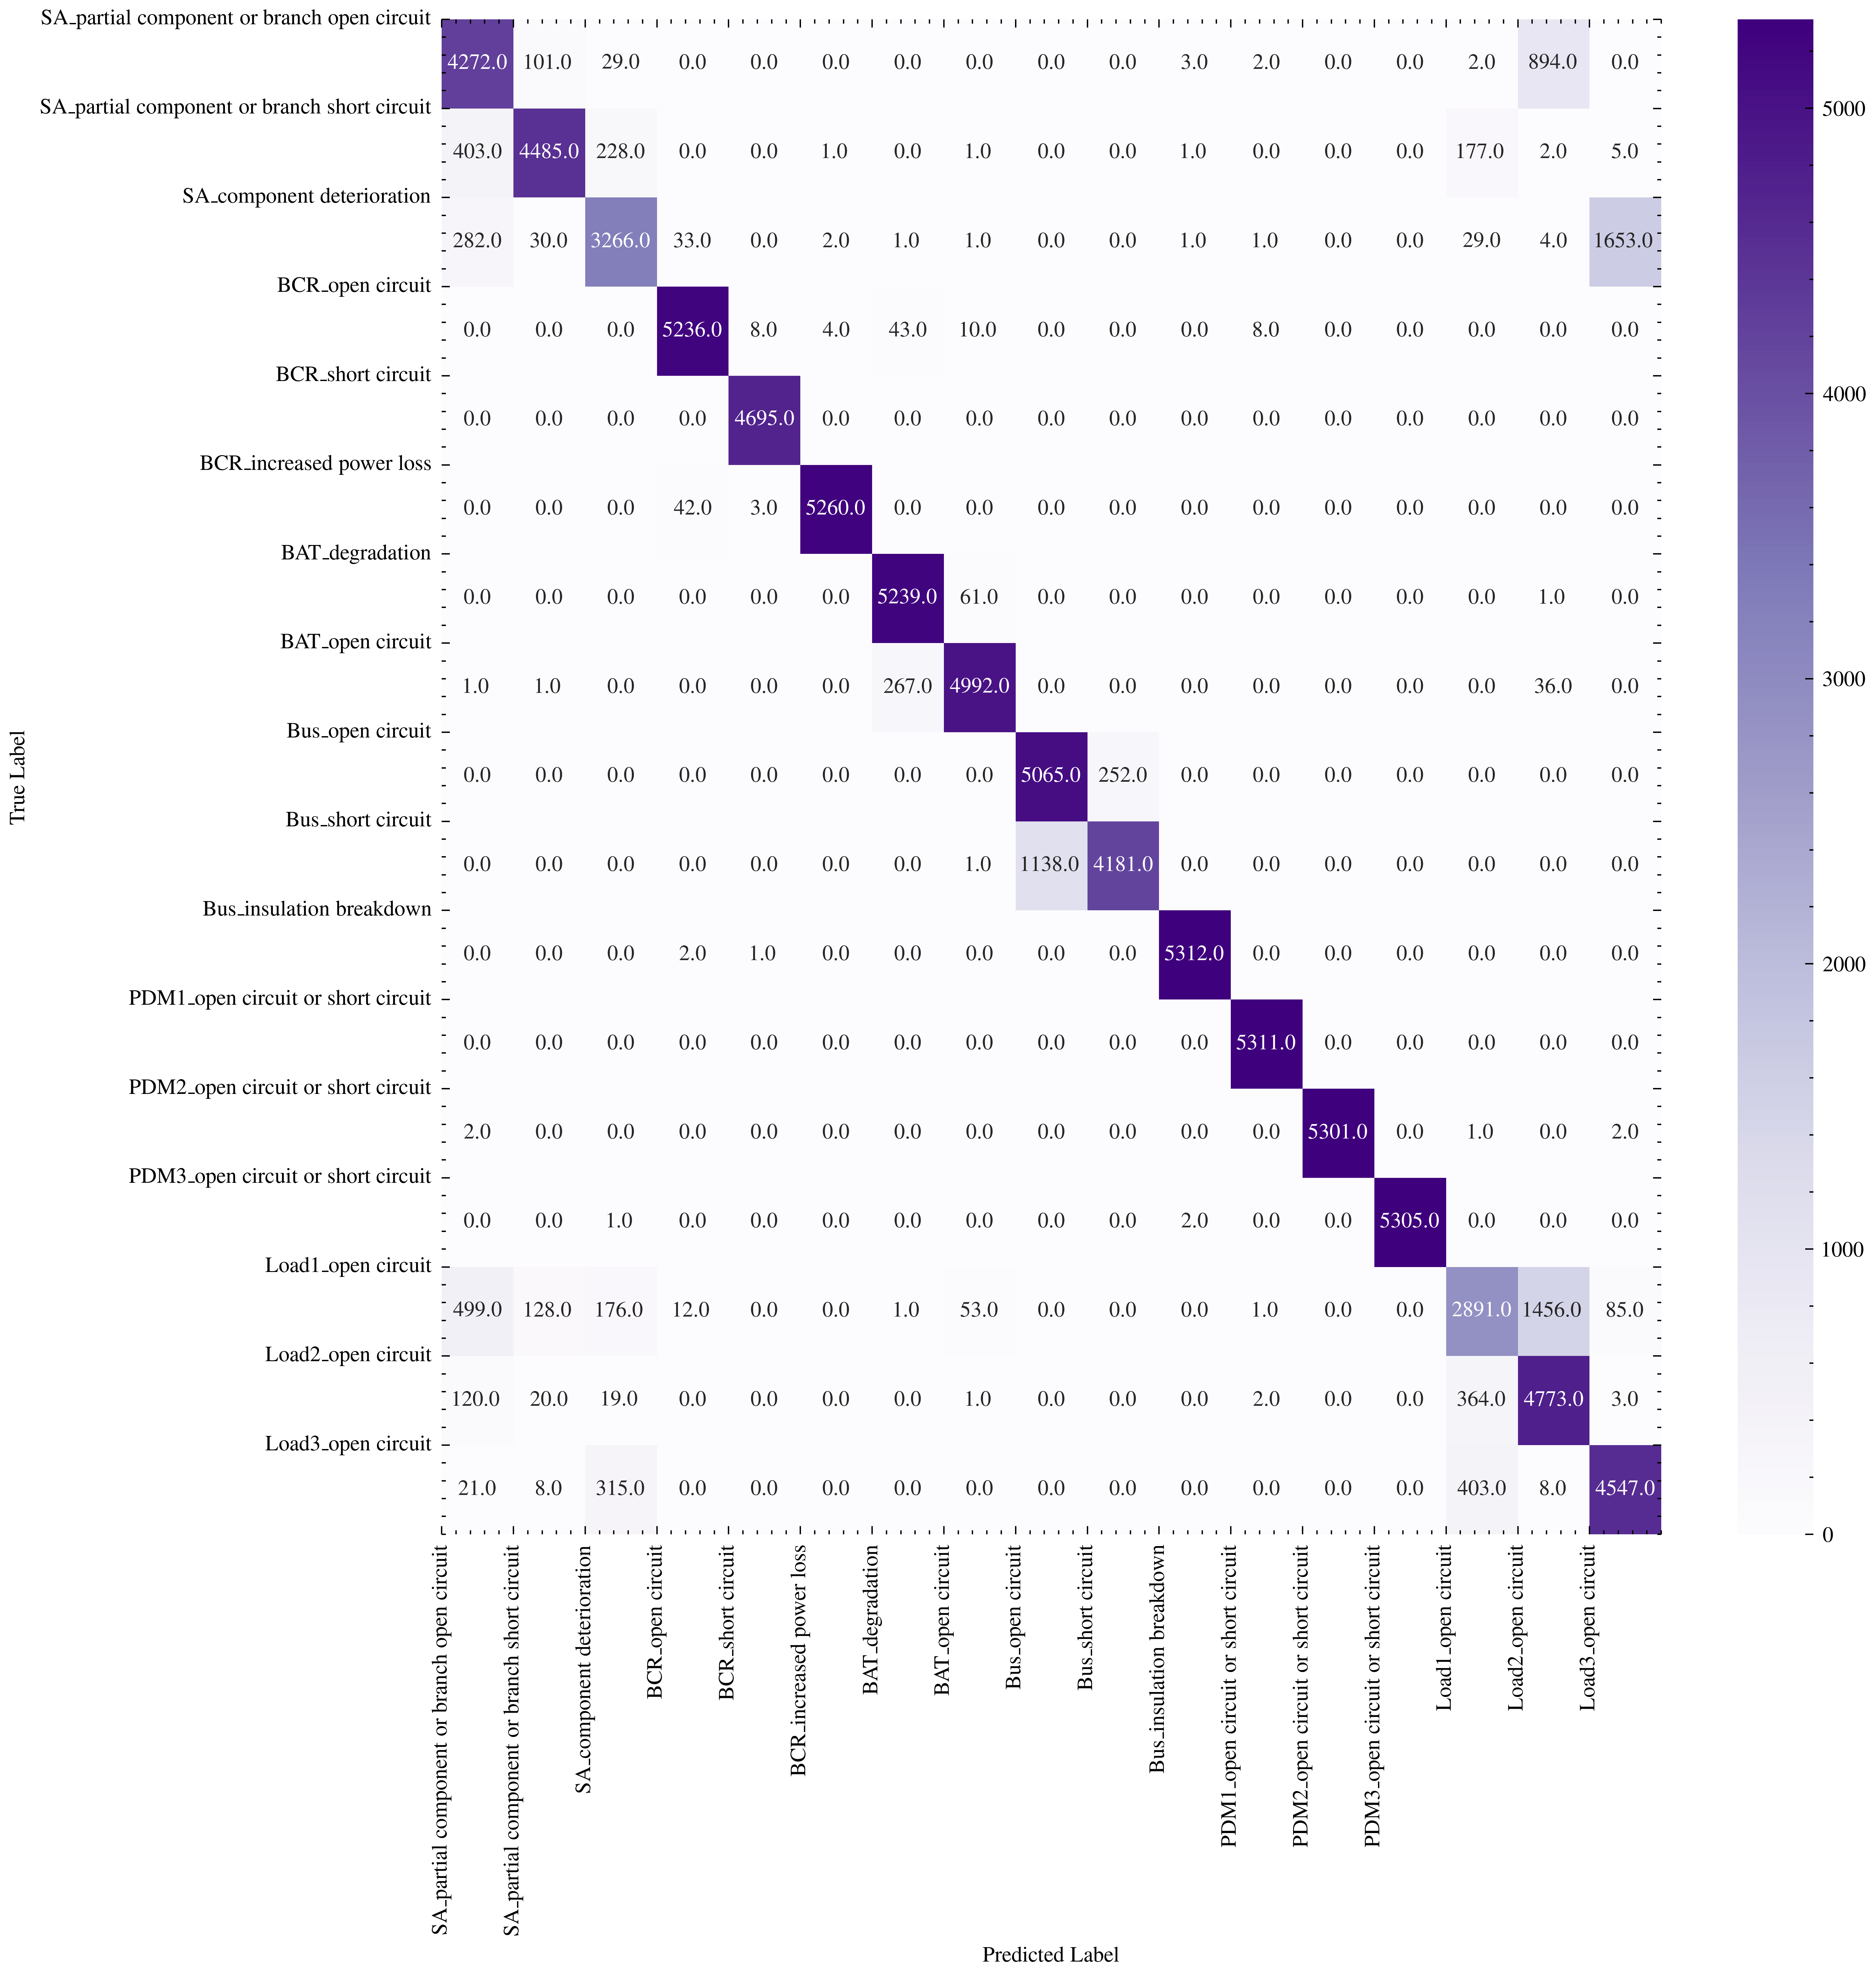

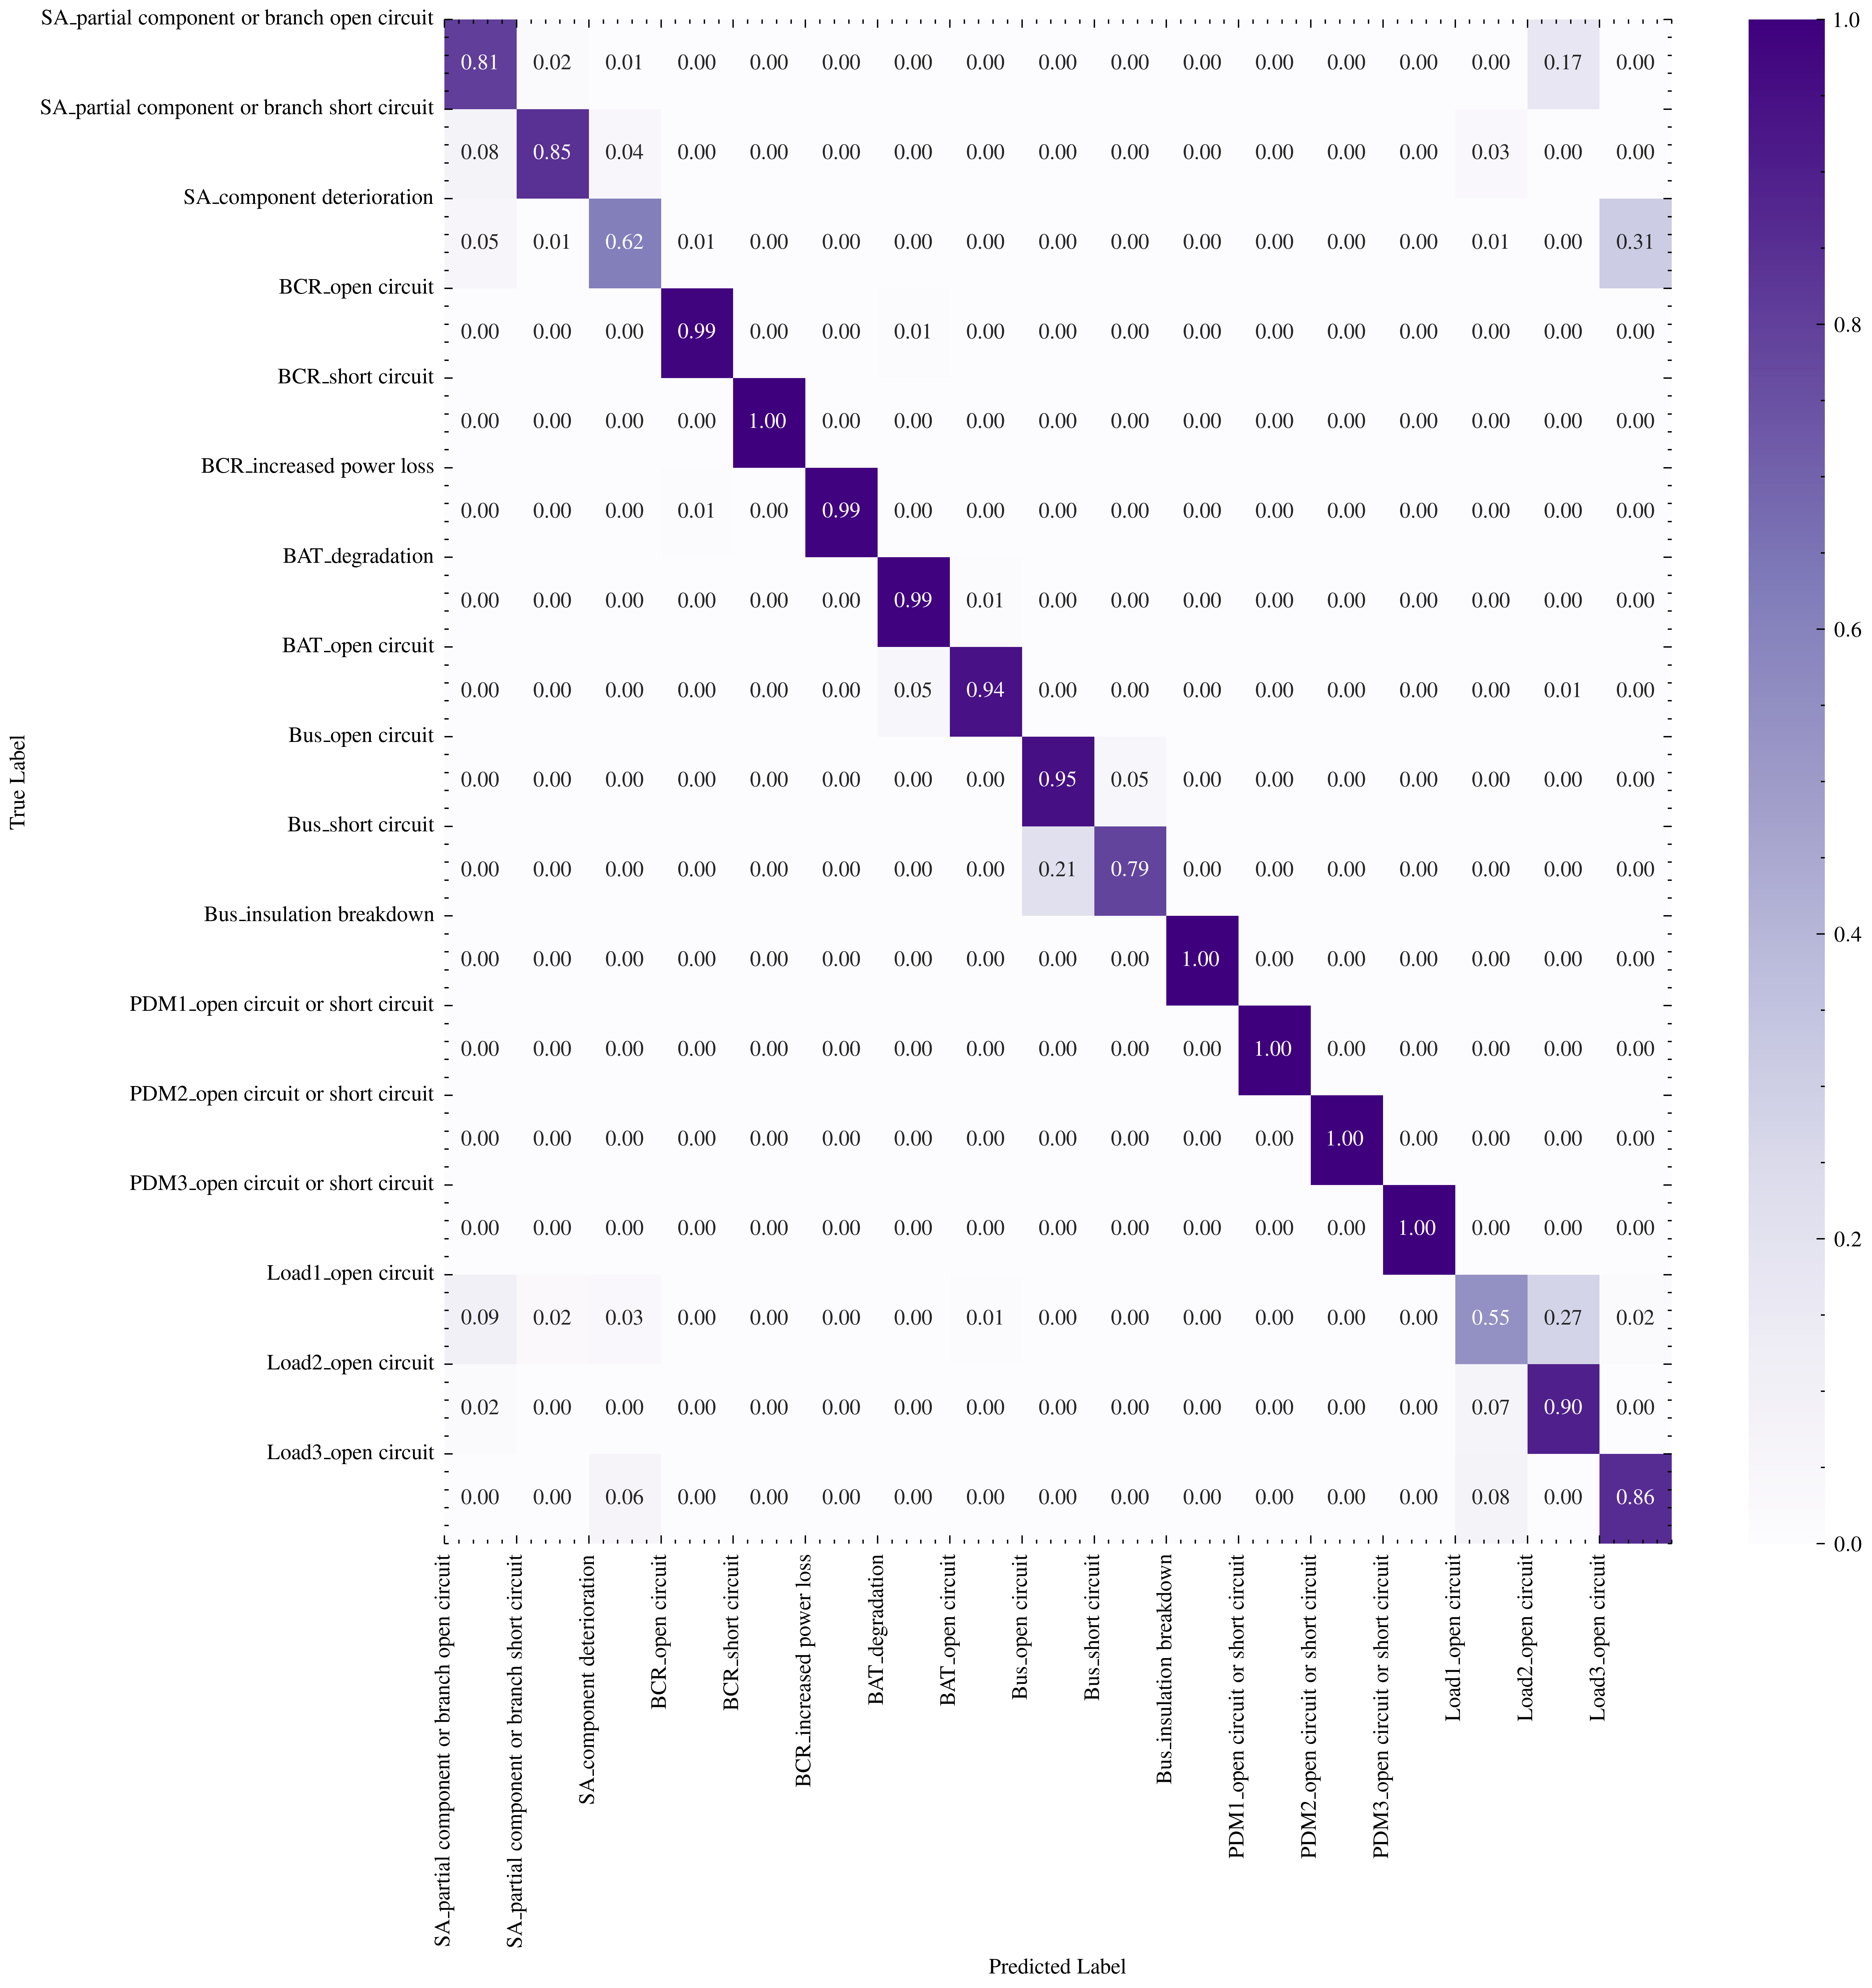

In [ ]:
# 画个各类异常的混淆矩阵热图
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import random

fault_dict = {
    # 0: 'normal',
    1: 'SA_partial component or branch open circuit',
    2: 'SA_partial component or branch short circuit',
    3: 'SA_component deterioration',
    4: 'BCR_open circuit',
    5: 'BCR_short circuit',
    6: 'BCR_increased power loss',
    7: 'BAT_degradation',
    8: 'BAT_open circuit',
    9: 'Bus_open circuit',
    10: 'Bus_short circuit',
    11: 'Bus_insulation breakdown',
    12: 'PDM1_open circuit or short circuit',
    13: 'PDM2_open circuit or short circuit',
    14: 'PDM3_open circuit or short circuit',
    15: 'Load1_open circuit',
    16: 'Load2_open circuit',
    17: 'Load3_open circuit'
}

fault_dict_chinese = {
    # '正常': 0,
    '太阳能电池板部分元件或支路开路': 1,
    '太阳能电池板部分元件或支路短路': 2,
    '太阳能电池板元件老化': 3,
    'BCR开路': 4,
    'BCR短路': 5,
    'BCR功率损耗增加': 6,
    '电池组老化': 7,
    '电池组开路': 8,
    '母线开路': 9,
    '母线短路': 10,
    '母线绝缘击穿': 11,
    'PDM1开路或短路': 12,
    'PDM2开路或短路': 13,
    'PDM3开路或短路': 14,
    '负载1开路': 15,
    '负载2开路': 16,
    '负载3开路': 17
    # 0: '正常',
    # 1: '太阳能电池板部分元件或支路开路',
    # 2: '太阳能电池板部分元件或支路短路',
    # 3: '太阳能电池板元件老化',
    # 4: 'BCR开路',
    # 5: 'BCR短路',
    # 6: 'BCR功率损耗增加',
    # 7: '电池组老化',
    # 8: '电池组开路',
    # 9: '母线开路',
    # 10: '母线短路',
    # 11: '母线绝缘击穿',
    # 12: 'PDM1开路或短路',
    # 13: 'PDM2开路或短路',
    # 14: 'PDM3开路或短路',
    # 15: '负载1开路',
    # 16: '负载2开路',
    # 17: '负载3开路'
}

responses_list = []
# 读取以responses_list_start_from_开头的文件，从responses_list_start_from_0.json开始，数字从小到大读取
# f"/data/DiYi/MyWorks_Results/DY-LLM_4SPS-PHM_Project/results/responses_list_start_from_{num_start}.json"
# 读取出来的列表逐个加到responses_list里面去
num_start_list = []
for filename in os.listdir("/data/DiYi/MyWorks_Results/DY-LLM_4SPS-PHM_Project/results"):
    match = re.match(r"responses_list_start_from_(\d+).json", filename)
    if match: num_start_list.append(int(match.group(1)))
if 0 not in num_start_list: raise ValueError("No 000000 files found")
num_start_list.sort()
for num_start in num_start_list:
    with open(f"/data/DiYi/MyWorks_Results/DY-LLM_4SPS-PHM_Project/results/responses_list_start_from_{num_start}.json", "r") as f:
        responses_list.extend(json.load(f))
if len(responses_list) != len(label_test):
    raise ValueError("responses_list length does not match label_test length")
# responses_list中每个元素里 ‘###回答’后面的字符串存为result_list的元素
def extract_answer(response):
    # 使用正则表达式匹配 '### 回答:' 后面的内容
    if "### 回答:" in response:
        result = response.split("### 回答:")[1].strip()
    else:
        if "###回答:" in response:
            result = response.split("###回答:")[1].strip()
        else:
            if  "### 回答：" in response:
                result = response.split("### 回答：")[1].strip()
            else:
                if "###回答：" in response:
                    result = response.split("###回答：")[1].strip()
                else:
                    print("no ###回答 in response:", response)
                    result = "no answer found"
    return result

# label_test = [test_data[i]["output"] for i in index_list] 
label_test = label_test  # 测试集标签列表，字符串
result_test = [extract_answer(response) for response in responses_list]
# 模型诊断结果列表，字符串
label_list = []  # 测试集标签列表，1-17
result_list = []  # 模型诊断结果列表，1-17

for label in label_test:
    label_list.append(fault_dict_chinese[label])
for response in result_test:
    this_result = random.randint(0, len(fault_dict_chinese))
    last_common_chars_len = 0
    for key, value in fault_dict_chinese.items():        
        if key in response:
            this_result = value
            break
        else:
            # somethimes reponse is Similar but not the same   # 计算共同字符数量
            common_chars = set(response) & set(key)
            if len(common_chars) > last_common_chars_len:
                last_common_chars_len = len(common_chars)
                this_result = value
    result_list.append(this_result)

# 计算混淆矩阵，第i行第j的元素表示第i类样本被预测为第j类的数量
confusion_matrix = np.zeros((len(fault_dict), len(fault_dict)))
for true_label, pred_label in zip(label_list, result_list):
    confusion_matrix[true_label-1, pred_label-1] += 1
    # print(confusion_matrix)

# 计算归一化后的混淆矩阵，第i行第j的元素表示第i类样本被预测为第j类的比例
norm_confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]

# 将混淆矩阵和归一化混淆矩阵保存为csv文件
csv_file_path = '/data/DiYi/MyWorks_Results/DY-LLM_4SPS-PHM_Project/results/confusion_matrix.csv'
import pandas as pd
confusion_matrix_df = pd.DataFrame(confusion_matrix, index=list(fault_dict.values()), columns=list(fault_dict.values()))
norm_confusion_matrix_df = pd.DataFrame(norm_confusion_matrix, index=list(fault_dict.values()), columns=list(fault_dict.values()))
confusion_matrix_df.to_csv(csv_file_path)
norm_confusion_matrix_df.to_csv(csv_file_path.replace(".csv", "_norm.csv"))

# 打印或者画图的形式显示混淆矩阵，在jupyter cell下方直接画图
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 10))
# plt.imshow(confusion_matrix, cmap='Blues')
sns.heatmap(confusion_matrix, annot=True, fmt='.1f', cmap='Purples')
# plt.colorbar()
plt.xticks(range(len(fault_dict)), list(fault_dict.values()), rotation=90)
plt.yticks(range(len(fault_dict)), list(fault_dict.values()), rotation=0)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
plt.figure(figsize=(10, 10))
# plt.imshow(norm_confusion_matrix, cmap='Blues')
sns.heatmap(norm_confusion_matrix, annot=True, fmt='.2f', cmap='Purples')
# plt.colorbar()
plt.xticks(range(len(fault_dict)), list(fault_dict.values()), rotation=90)
plt.yticks(range(len(fault_dict)), list(fault_dict.values()), rotation=0)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 绘制混淆矩阵热图（归一化）
import sys
import os
# 获取当前文件所在目录的父目录路径
parent_dir = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..'))
# 或明确指定路径
# parent_dir = '/home/dy29/MyWorks_Codes/15_LLM_4_SPS_PHM'
# 将父目录添加到 Python 路径
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
# 删除相关旧模块的缓存，重新导入
if 'utils.plot_heatmap' in sys.modules:
    del sys.modules['utils.plot_heatmap']
if 'utils' in sys.modules:
    del sys.modules['utils']
from AD_repository.utils.plot_heatmap import plot_W_heatmap
pdf = PdfPages('/data/DiYi/MyWorks_Results/DY-LLM_4SPS-PHM_Project/results/confusion_matrix.pdf')
# 画归一化的
pdf = plot_W_heatmap(norm_confusion_matrix, indexs_list=list(fault_dict.values()), columns_list=list(fault_dict.values()), pdf=pdf)
# 再画列名字直接是Type1到Type17
pdf = plot_W_heatmap(norm_confusion_matrix, indexs_list=[f'Type{i+1}' for i in range(len(fault_dict))], columns_list=[f'Type{i+1}' for i in range(len(fault_dict))], pdf=pdf)
# 画没归一化的
pdf = plot_W_heatmap(confusion_matrix, indexs_list=list(fault_dict.values()), columns_list=list(fault_dict.values()), fig_size=(8,5), pdf=pdf)
pdf = plot_W_heatmap(confusion_matrix, indexs_list=[f'Type{i+1}' for i in range(len(fault_dict))], columns_list=[f'Type{i+1}' for i in range(len(fault_dict))], fig_size=(8,5), pdf=pdf)
pdf.close()

### 将微调后的模型保存为 GGUF 格式

In [56]:
# # 为保证保存完整模型
# # 先合并量化参数
# model = model.merge_and_unload()
# # 再保存
# model.save_pretrained("/data/DiYi/MyWorks_Results/DY-LLM_4SPS-PHM_Project/finetuned_LLMmodel_HF", 
#                       save_embedding_layers=True, 
#                       safe_serialization=True,
#                       save_quantized=True  # 显式保存量化参数
#                       )
# tokenizer.save_pretrained("/data/DiYi/MyWorks_Results/DY-LLM_4SPS-PHM_Project/finetuned_LLMmodel_HF")

# 将模型保存为 8 位量化格式（Q8_0）
# 这种格式文件小且运行快，适合部署到资源受限的设备
model.save_pretrained_gguf("/data/DiYi/MyWorks_Results/DY-LLM_4SPS-PHM_Project/finetuned_LLMmodel_gguf_q8_0", tokenizer, quantization_method = "q8_0")
tokenizer.save_pretrained("/data/DiYi/MyWorks_Results/DY-LLM_4SPS-PHM_Project/finetuned_LLMmodel_gguf_q8_0")

# # 将模型保存为 16 位量化格式（f16）
# # 16 位量化精度更高，但文件稍大
model.save_pretrained_gguf("/data/DiYi/MyWorks_Results/DY-LLM_4SPS-PHM_Project/finetuned_LLMmodel_gguf_f16", tokenizer, quantization_method = "f16")
tokenizer.save_pretrained("/data/DiYi/MyWorks_Results/DY-LLM_4SPS-PHM_Project/finetuned_LLMmodel_gguf_f16")

# # 将模型保存为 4 位量化格式（q4_k_m）
# # 4 位量化文件最小，但精度可能稍低
# model.save_pretrained_gguf("/data/DiYi/MyWorks_Results/DY-LLM_4SPS-PHM_Project/finetuned_LLMmodel_gguf_q4_k_m", tokenizer, quantization_method = "q4_k_m")
# tokenizer.save_pretrained("/data/DiYi/MyWorks_Results/DY-LLM_4SPS-PHM_Project/finetuned_LLMmodel_gguf_q4_k_m")

Unsloth: Merging 4bit and LoRA weights to 16bit...
Unsloth: Will use up to 305.77 out of 502.49 RAM for saving.
Unsloth: Saving model... This might take 5 minutes ...


100%|██████████| 40/40 [00:04<00:00,  9.30it/s]


Unsloth: Saving tokenizer... Done.
Done.
==((====))==  Unsloth: Conversion from QLoRA to GGUF information
   \\   /|    [0] Installing llama.cpp might take 3 minutes.
O^O/ \_/ \    [1] Converting HF to GGUF 16bits might take 3 minutes.
\        /    [2] Converting GGUF 16bits to ['q8_0'] might take 10 minutes each.
 "-____-"     In total, you will have to wait at least 16 minutes.

Unsloth: Installing llama.cpp. This might take 3 minutes...


RuntimeError: Unsloth: The file ('llama.cpp/llama-quantize' or 'llama.cpp/llama-quantize.exe' if you are on Windows WSL) or 'llama.cpp/quantize' does not exist.
But we expect this file to exist! Maybe the llama.cpp developers changed the name or check extension of the llama-quantize file.

### 将微调后的模型上传到 HuggingFace

In [ ]:
# # 导入 Hugging Face Hub 的 create_repo 函数，用于创建一个新的模型仓库
# from huggingface_hub import create_repo

# # 在 Hugging Face Hub 上创建一个新的模型仓库
# create_repo("Conard/fortunetelling", token=HUGGINGFACE_TOKEN, exist_ok=True)

# # 将模型和分词器上传到 Hugging Face Hub 上的仓库
# model.push_to_hub_gguf("Conard/fortunetelling", tokenizer, token=HUGGINGFACE_TOKEN)

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 